<a href="https://colab.research.google.com/github/sushirito/ArsenicFR/blob/main/ArsenicAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# === Colab setup ===
# If in Colab, run this to mount Drive
from google.colab import drive  # safe if not in Colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Only One Training

Epoch 200, Loss=0.000007
Epoch 400, Loss=0.000002
Epoch 600, Loss=0.000003
Epoch 800, Loss=0.000002
Epoch 1000, Loss=0.000001
Epoch 1200, Loss=0.000001
Epoch 1400, Loss=0.000000
Epoch 1600, Loss=0.000001
Epoch 1800, Loss=0.000001
Epoch 2000, Loss=0.000001


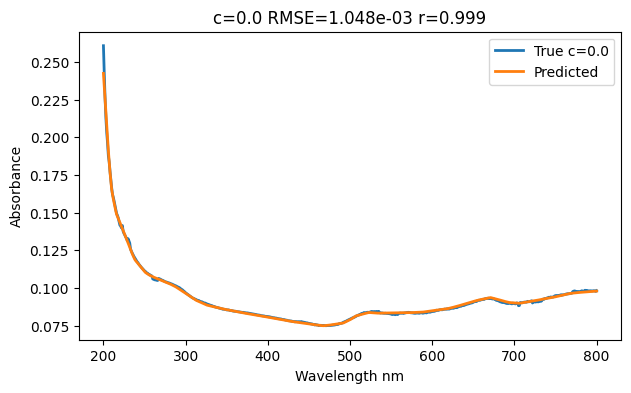

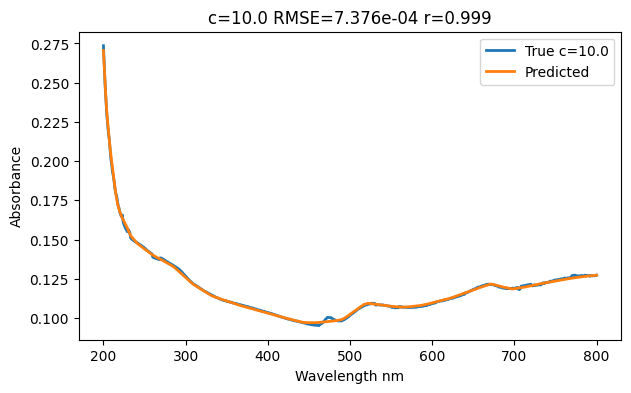

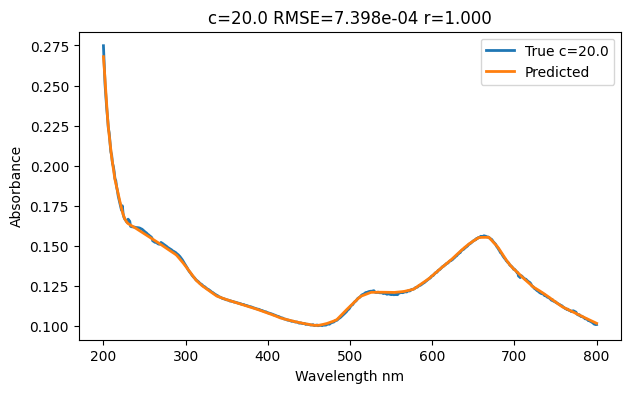

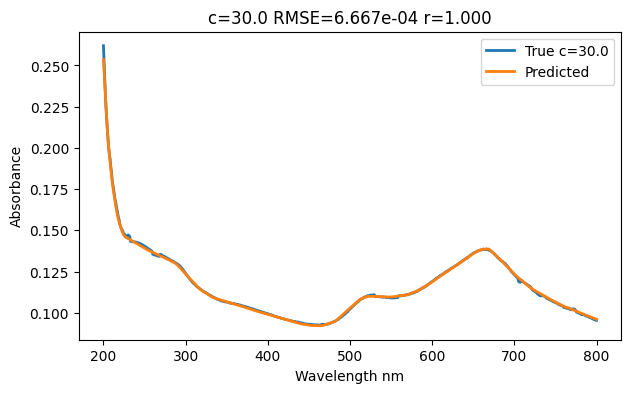

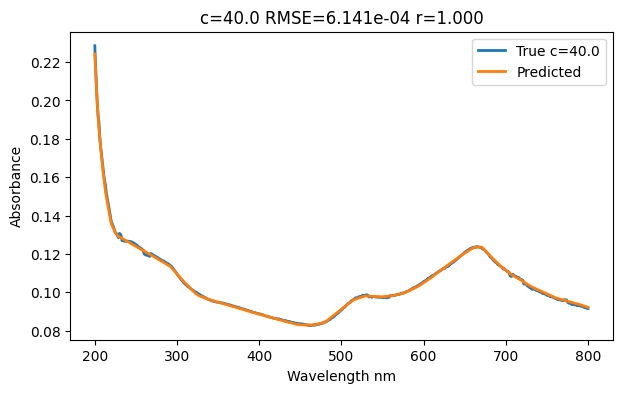

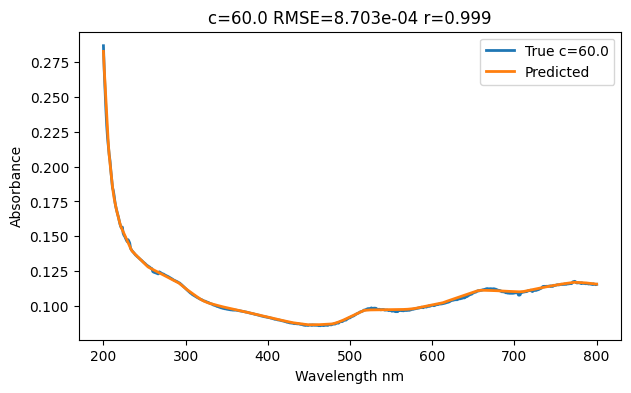

Saved CSV with raw true spectra + predictions.


In [30]:
import os, random, json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# ------------------------------
# 1. Data loading
# ------------------------------
def load_uvvis_csv(path, baseline_correct=True):
    df = pd.read_csv(path)
    df.columns = [str(c).strip() for c in df.columns]
    assert "Wavelength" in df.columns, "CSV must have 'Wavelength'"

    wl = df["Wavelength"].to_numpy(dtype=np.float32)

    # Identify numeric concentration columns
    conc_cols = []
    for c in df.columns:
        if c == "Wavelength":
            continue
        try:
            float(c)
            conc_cols.append(c)
        except ValueError:
            pass

    # Sort by numeric concentration
    conc_vals = np.array(sorted([float(c) for c in conc_cols], key=float), dtype=np.float32)
    conc_cols_sorted = [str(int(c)) if float(c).is_integer() else str(c) for c in conc_vals]

    # Absorbance matrix
    A = np.stack([df[c].to_numpy(dtype=np.float32) for c in conc_cols_sorted], axis=1)  # [λ, conc]

    if baseline_correct:
        idx_800 = int(np.argmin(np.abs(wl - 800.0)))
        base = A[idx_800:idx_800+1, :]
        A = A - base

    return wl, conc_vals, A

# ------------------------------
# 2. Load datasets
# ------------------------------
DATA_CSV = "/content/drive/MyDrive/ArsenicSTS/UVVisData/0.30MB_AuNP_As.csv"

# Baseline-corrected for training
wl_train, concs_train, A_train = load_uvvis_csv(DATA_CSV, baseline_correct=True)

# Raw spectra for plotting
wl_raw, concs_raw, A_raw = load_uvvis_csv(DATA_CSV, baseline_correct=False)
RAW_SPECTRA = {c: A_raw[:, i] for i, c in enumerate(concs_raw)}

# ------------------------------
# 3. Simple coordinate MLP
# ------------------------------
class CoordMLP(nn.Module):
    def __init__(self, in_dim=2, hidden=128, depth=4, out_dim=1):
        super().__init__()
        layers = []
        layers.append(nn.Linear(in_dim, hidden))
        layers.append(nn.ReLU())
        for _ in range(depth - 1):
            layers.append(nn.Linear(hidden, hidden))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# ------------------------------
# 4. Training dataset prep
# ------------------------------
wl_norm = (wl_train - wl_train.min()) / (wl_train.max() - wl_train.min())
c_norm  = (concs_train - concs_train.min()) / (concs_train.max() - concs_train.min())

WL_grid, C_grid = np.meshgrid(wl_norm, c_norm, indexing='ij')
X_train = np.stack([WL_grid.flatten(), C_grid.flatten()], axis=1)
y_train = A_train.flatten()[:, None]

ds_train = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                         torch.tensor(y_train, dtype=torch.float32))
dl_train = DataLoader(ds_train, batch_size=1024, shuffle=True)

# ------------------------------
# 5. Training loop
# ------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1337)
model = CoordMLP().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(2000):
    for xb, yb in dl_train:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
    if (epoch+1) % 200 == 0:
        print(f"Epoch {epoch+1}, Loss={loss.item():.6f}")

# ------------------------------
# 6. Inference function
# ------------------------------
def predict_spectrum(c_val):
    c_norm_val = (c_val - concs_train.min()) / (concs_train.max() - concs_train.min())
    wl_norm_vals = (wl_train - wl_train.min()) / (wl_train.max() - wl_train.min())
    X_pred = np.stack([wl_norm_vals, np.full_like(wl_norm_vals, c_norm_val)], axis=1)
    with torch.no_grad():
        y_pred = model(torch.tensor(X_pred, dtype=torch.float32).to(DEVICE)).cpu().numpy().squeeze()

    # Add back baseline offset for this concentration
    conc_index = np.where(concs_raw == c_val)[0][0]
    idx_800 = np.argmin(np.abs(wl_raw - 800.0))
    baseline_offset = A_raw[idx_800, conc_index]
    y_pred = y_pred + baseline_offset

    return wl_train, y_pred

# ------------------------------
# 7. Plotting — True = RAW data
# ------------------------------
for c_val in concs_train:
    wl_pred, A_pred = predict_spectrum(c_val)
    A_true = RAW_SPECTRA[c_val]  # unmodified
    rmse = np.sqrt(np.mean((A_true - A_pred)**2))
    r = np.corrcoef(A_true, A_pred)[0,1]
    plt.figure(figsize=(7,4))
    plt.plot(wl_pred, A_true, label=f"True c={c_val}", lw=2)
    plt.plot(wl_pred, A_pred, label="Predicted", lw=2)
    plt.title(f"c={c_val} RMSE={rmse:.3e} r={r:.3f}")
    plt.xlabel("Wavelength nm"); plt.ylabel("Absorbance")
    plt.legend()
    plt.show()

# ------------------------------
# 8. Save combined results CSV
# ------------------------------
out_rows = []
for c_val in concs_train:
    wl_pred, A_pred = predict_spectrum(c_val)
    A_true = RAW_SPECTRA[c_val]
    for w, t, p in zip(wl_pred, A_true, A_pred):
        out_rows.append({"Wavelength": w, "Concentration": c_val,
                         "Absorbance_True": t, "Absorbance_Pred": p})

df_out = pd.DataFrame(out_rows)
df_out.to_csv("/content/drive/MyDrive/ArsenicSTS/uvvis_predictions_raw.csv", index=False)
print("Saved CSV with raw true spectra + predictions.")

In [31]:
# Generate a grid of predicted raw spectra at many concentrations and save to CSV

import numpy as np
import pandas as pd
import os
import torch

# --- Tunables ---
C_START = 0     # µg/L
C_END   = 60.0     # µg/L
C_STEP  = 0.5      # µg/L spacing
OUT_CSV = "/content/drive/MyDrive/ArsenicSTS/uvvis_pred_grid_raw.csv"

# Assumes these are already in memory from your training notebook:
# model (trained), DEVICE, wl_train, concs_train, wl_raw, concs_raw, A_raw

model.eval()

# Helper: predict baseline-corrected spectrum from model, then add raw baseline via interpolation
@torch.no_grad()
def predict_raw_spectrum_at(c_val: float):
    # 1) Model prediction in baseline-corrected space
    c_norm_val = (c_val - concs_train.min()) / (concs_train.max() - concs_train.min())
    wl_norm_vals = (wl_train - wl_train.min()) / (wl_train.max() - wl_train.min())
    X_pred = np.stack([wl_norm_vals, np.full_like(wl_norm_vals, c_norm_val)], axis=1)
    y_bc = model(torch.tensor(X_pred, dtype=torch.float32, device=DEVICE)).cpu().numpy().squeeze()

    # 2) Add back the baseline at 800 nm using a linear interpolation from the raw data
    idx_800 = int(np.argmin(np.abs(wl_raw - 800.0)))
    baseline_curve = A_raw[idx_800, :]                 # shape [num_measured_concs]
    baseline_interp = np.interp(c_val, concs_raw, baseline_curve)  # flat outside range
    y_raw = y_bc + baseline_interp

    return y_raw  # length matches wl_train

# Build grid
concs_grid = np.round(np.arange(C_START, C_END + 1e-12, C_STEP), 6)

# Predict and collect
data = {"Wavelength": wl_train.astype(float)}
for c in concs_grid:
    y_raw = predict_raw_spectrum_at(float(c))
    # Column name like original CSV
    col_name = str(int(c)) if float(c).is_integer() else str(c)
    data[col_name] = y_raw.astype(float)

# Save wide CSV: Wavelength plus one column per concentration
df_out = pd.DataFrame(data)
os.makedirs(os.path.dirname(OUT_CSV), exist_ok=True)
df_out.to_csv(OUT_CSV, index=False)
print(f"Saved {len(concs_grid)} spectra to {OUT_CSV}")

Saved 121 spectra to /content/drive/MyDrive/ArsenicSTS/uvvis_pred_grid_raw.csv


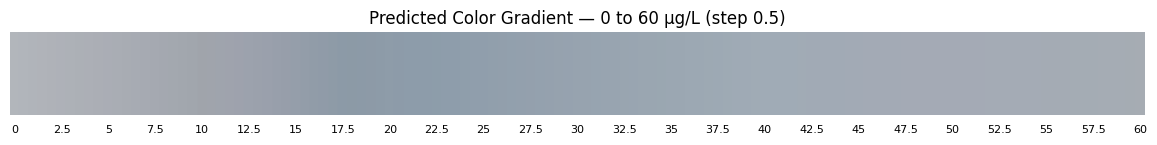

In [32]:
# Gradient of predicted colors across a dense concentration grid (e.g., 0..60 by 0.5)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from colour import SpectralDistribution, sd_to_XYZ, XYZ_to_sRGB
from colour import MSDS_CMFS, SDS_ILLUMINANTS

# --- Tunables ---
GRID_CSV     = "/content/drive/MyDrive/ArsenicSTS/uvvis_pred_grid_raw.csv"  # wide format you just saved
ABS_MULT     = 4.0     # same absorbance multiplier as before
LABEL_EVERY  = 5       # write a label every N swatches to avoid clutter

# Load and restrict to visible
df = pd.read_csv(GRID_CSV)
df.columns = df.columns.map(str).str.strip()
df["Wavelength"] = pd.to_numeric(df["Wavelength"], errors="coerce")
vis = df[(df["Wavelength"] >= 380) & (df["Wavelength"] <= 780)].copy()
wvl = vis["Wavelength"].values.astype(float)

# Identify concentration columns (everything except Wavelength), sort numerically
conc_cols = [c for c in vis.columns if c != "Wavelength"]
conc_pairs = sorted([(float(c), c) for c in conc_cols], key=lambda x: x[0])
concs_sorted = [p[0] for p in conc_pairs]
cols_sorted  = [p[1] for p in conc_pairs]

# CIE setup
cmfs       = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
illuminant = SDS_ILLUMINANTS['D65']

# Compute color for each concentration column
colors = []
for col in cols_sorted:
    A = vis[col].astype(float).values
    T = 10 ** (-ABS_MULT * A)  # absorbance -> transmittance
    sd = SpectralDistribution(dict(zip(wvl, T)))
    XYZ = sd_to_XYZ(sd, cmfs, illuminant) / 100.0
    rgb = np.clip(XYZ_to_sRGB(XYZ), 0, 1)
    colors.append(rgb)

# Plot a long gradient bar with one swatch per concentration
w = max(8, min(24, 2 + 0.08 * len(colors)))  # auto width
fig, ax = plt.subplots(figsize=(w, 1.6))
for i, c in enumerate(colors):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=c))
    if (i % LABEL_EVERY) == 0 or i == len(colors) - 1:
        ax.text(i + 0.5, -0.12, f"{concs_sorted[i]:g}", ha="center", va="top", fontsize=8)

ax.set_xlim(0, len(colors))
ax.set_ylim(0, 1)
ax.axis("off")

# Nice title showing range and step (if evenly spaced)
if len(concs_sorted) > 1:
    diffs = np.diff(concs_sorted)
    step = diffs[0] if np.allclose(diffs, diffs[0]) else "var"
    title = f"Predicted Color Gradient — {concs_sorted[0]:g} to {concs_sorted[-1]:g} µg/L"
    if step != "var":
        title += f" (step {step:g})"
else:
    title = f"Predicted Color — {concs_sorted[0]:g} µg/L"
plt.title(title)
plt.tight_layout()
plt.show()

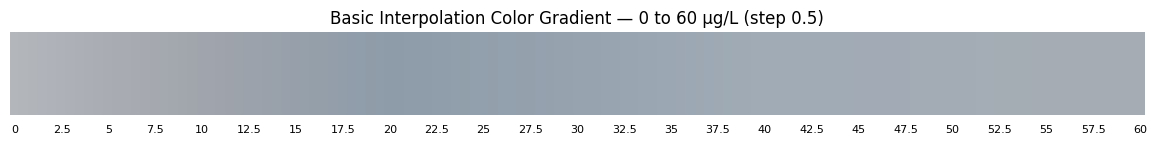

In [34]:
# Basic interpolation gradient (no neural net): colors from linearly interpolated *measured* spectra
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from colour import SpectralDistribution, sd_to_XYZ, XYZ_to_sRGB
from colour import MSDS_CMFS, SDS_ILLUMINANTS

# --- Tunables ---
SOURCE_CSV   = "/content/drive/MyDrive/ArsenicSTS/UVVisData/0.30MB_AuNP_As.csv"  # raw measured spectra
C_START      = 0.0
C_END        = 60.0
C_STEP       = 0.5
ABS_MULT     = 4.0     # same absorbance multiplier as before
LABEL_EVERY  = 5       # label every N swatches

# Load raw measured spectra
df = pd.read_csv(SOURCE_CSV)
df.columns = df.columns.map(str).str.strip()
df["Wavelength"] = pd.to_numeric(df["Wavelength"], errors="coerce")

# Identify numeric concentration columns and sort
conc_cols = []
for c in df.columns:
    if c == "Wavelength":
        continue
    try:
        float(c)
        conc_cols.append(c)
    except:
        pass
concs_known = np.array(sorted([float(c) for c in conc_cols], key=float), dtype=float)
cols_sorted = [str(int(c)) if float(c).is_integer() else str(c) for c in concs_known]

# Visible subset
vis = df[(df["Wavelength"] >= 380) & (df["Wavelength"] <= 780)].copy()
wvl = vis["Wavelength"].values.astype(float)
A_known = np.stack([vis[c].astype(float).values for c in cols_sorted], axis=1)  # shape [λ, K]

# Build target concentration grid
concs_grid = np.round(np.arange(C_START, C_END + 1e-12, C_STEP), 6)

# Linear interpolation across concentration for each wavelength
# For each λ-row, interpolate A_known[row, :] over concs_known to concs_grid
A_interp = np.vstack([
    np.interp(concs_grid, concs_known, A_known[row, :])  # clamp at ends
    for row in range(A_known.shape[0])
])  # shape [λ, |grid|]

# CIE setup
cmfs       = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
illuminant = SDS_ILLUMINANTS['D65']

# Compute color per grid concentration
colors = []
for j in range(A_interp.shape[1]):
    A = A_interp[:, j]
    T = 10 ** (-ABS_MULT * A)
    sd = SpectralDistribution(dict(zip(wvl, T)))
    XYZ = sd_to_XYZ(sd, cmfs, illuminant) / 100.0
    rgb = np.clip(XYZ_to_sRGB(XYZ), 0, 1)
    colors.append(rgb)

# Plot gradient
w = max(8, min(24, 2 + 0.08 * len(colors)))
fig, ax = plt.subplots(figsize=(w, 1.6))
for i, c in enumerate(colors):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=c))
    if (i % LABEL_EVERY) == 0 or i == len(colors) - 1:
        ax.text(i + 0.5, -0.12, f"{concs_grid[i]:g}", ha="center", va="top", fontsize=8)

ax.set_xlim(0, len(colors))
ax.set_ylim(0, 1)
ax.axis("off")

# Title
if len(concs_grid) > 1:
    diffs = np.diff(concs_grid)
    step = diffs[0] if np.allclose(diffs, diffs[0]) else "var"
    title = f"Basic Interpolation Color Gradient — {concs_grid[0]:g} to {concs_grid[-1]:g} µg/L"
    if step != "var":
        title += f" (step {step:g})"
else:
    title = f"Basic Interpolation Color — {concs_grid[0]:g} µg/L"
plt.title(title)
plt.tight_layout()
plt.show()


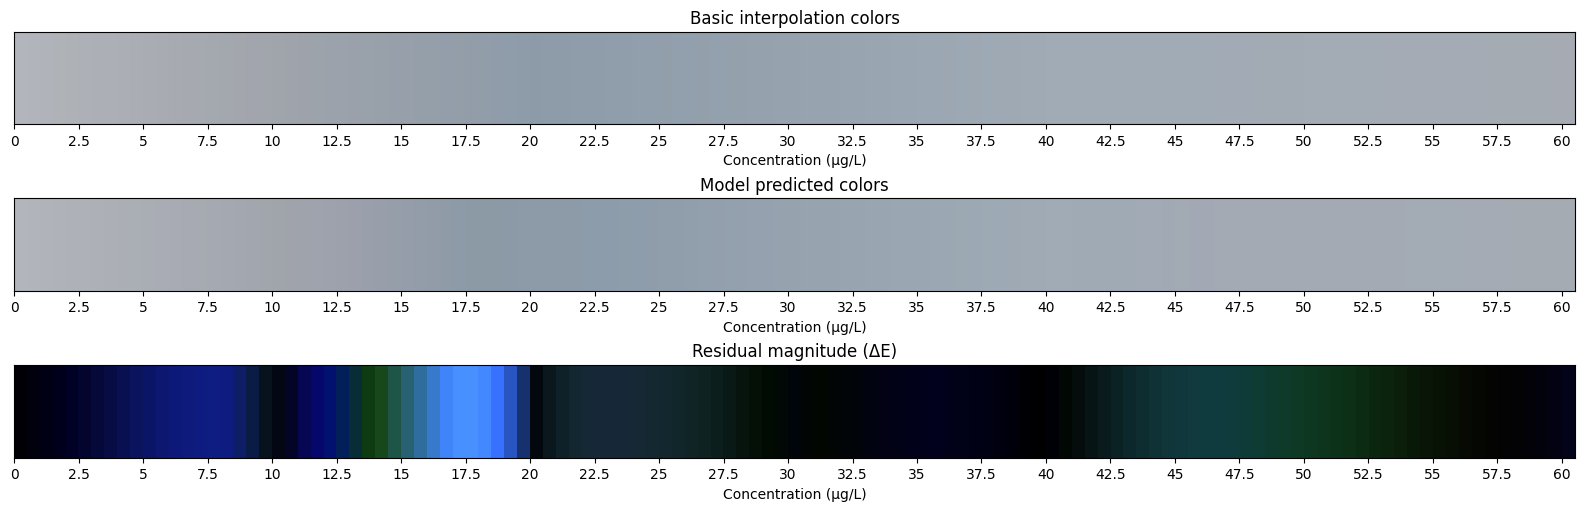

In [49]:
# One cell: basic vs predicted color gradients + residual (ΔE) bar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colour import SpectralDistribution, sd_to_XYZ, XYZ_to_sRGB, XYZ_to_Lab
from colour import MSDS_CMFS, SDS_ILLUMINANTS

# -------- Tunables --------
PRED_GRID_CSV = "/content/drive/MyDrive/ArsenicSTS/uvvis_pred_grid_raw.csv"   # from your model cell
MEASURED_CSV  = "/content/drive/MyDrive/ArsenicSTS/UVVisData/0.30MB_AuNP_As.csv"
ABS_MULT      = 4.0
LABEL_EVERY   = 5

# -------- Colour-science setup --------
cmfs       = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
illuminant = SDS_ILLUMINANTS['D65']

def spectra_to_rgb_and_lab(wavelengths, absorbance):
    """Convert an absorbance spectrum to sRGB and Lab (D65) via Beer–Lambert transmittance."""
    T = 10 ** (-ABS_MULT * absorbance)  # absorbance -> transmittance
    sd = SpectralDistribution(dict(zip(wavelengths, T)))
    XYZ = sd_to_XYZ(sd, cmfs, illuminant) / 100.0
    rgb = np.clip(XYZ_to_sRGB(XYZ), 0, 1)
    Lab = XYZ_to_Lab(XYZ, illuminant=illuminant)
    return rgb, Lab

# -------- Load predicted grid --------
df_pred = pd.read_csv(PRED_GRID_CSV)
df_pred.columns = df_pred.columns.map(str).str.strip()
df_pred["Wavelength"] = pd.to_numeric(df_pred["Wavelength"], errors="coerce")
vis_pred = df_pred[(df_pred["Wavelength"] >= 380) & (df_pred["Wavelength"] <= 780)].copy()
wvl = vis_pred["Wavelength"].values.astype(float)

# Concentration grid from predicted CSV
pred_pairs = sorted([(float(c), c) for c in df_pred.columns if c != "Wavelength"], key=lambda x: x[0])
grid_concs = np.array([p[0] for p in pred_pairs], dtype=float)
pred_cols  = [p[1] for p in pred_pairs]

# -------- Build basic interpolation on same grid --------
df_meas = pd.read_csv(MEASURED_CSV)
df_meas.columns = df_meas.columns.map(str).str.strip()
df_meas["Wavelength"] = pd.to_numeric(df_meas["Wavelength"], errors="coerce")
vis_meas = df_meas[(df_meas["Wavelength"] >= 380) & (df_meas["Wavelength"] <= 780)].copy()

conc_known = []
for c in vis_meas.columns:
    if c == "Wavelength":
        continue
    try:
        conc_known.append(float(c))
    except:
        pass
conc_known = np.array(sorted(conc_known), dtype=float)
known_cols = [str(int(c)) if float(c).is_integer() else str(c) for c in conc_known]
A_known = np.stack([vis_meas[c].astype(float).values for c in known_cols], axis=1)  # [λ, K]

# Interpolate absorbance at each wavelength to grid_concs
A_basic = np.vstack([
    np.interp(grid_concs, conc_known, A_known[i, :])  # [|grid|]
    for i in range(A_known.shape[0])
])  # [λ, |grid|]

# -------- Convert to colors for both sets --------
rgb_basic, lab_basic = [], []
rgb_pred,  lab_pred  = [], []

for j, col in enumerate(pred_cols):
    A_p = vis_pred[col].astype(float).values
    A_b = A_basic[:, j]
    c_rgb, c_lab = spectra_to_rgb_and_lab(wvl, A_b)
    p_rgb, p_lab = spectra_to_rgb_and_lab(wvl, A_p)
    rgb_basic.append(c_rgb)
    lab_basic.append(c_lab)
    rgb_pred.append(p_rgb)
    lab_pred.append(p_lab)

rgb_basic = np.array(rgb_basic)  # [N,3]
rgb_pred  = np.array(rgb_pred)   # [N,3]
lab_basic = np.array(lab_basic)  # [N,3]
lab_pred  = np.array(lab_pred)   # [N,3]

# -------- Residual magnitude per concentration: CIE76 ΔE --------
deltaE = np.linalg.norm(lab_pred - lab_basic, axis=1)  # [N]
# Normalize to [0,1] for grayscale display with robust scaling
p1, p99 = np.percentile(deltaE, [1, 99])
scale_min, scale_max = p1, max(p99, p1 + 1e-6)
deltaE_norm = np.clip((deltaE - scale_min) / (scale_max - scale_min), 0, 1)
rgb_resid = np.stack([deltaE_norm]*3, axis=1)  # grayscale RGB

# -------- Plot three bars in one cell (three subplots) --------
N = len(grid_concs)
# Build 1xN images for imshow
img_basic = rgb_basic[np.newaxis, :, :]   # [1,N,3]
img_pred  = rgb_pred[np.newaxis, :, :]    # [1,N,3]
img_resid = rgb_resid[np.newaxis, :, :]   # [1,N,3]

fig, axes = plt.subplots(3, 1, figsize=(max(10, 0.13*N), 5), constrained_layout=True)

# 1) Basic
axes[0].imshow(img_basic, aspect='auto', extent=[0, N, 0, 1])
axes[0].set_title("Basic interpolation colors")
axes[0].set_yticks([])
axes[0].set_xticks(range(0, N, LABEL_EVERY))
axes[0].set_xticklabels([f"{grid_concs[i]:g}" for i in range(0, N, LABEL_EVERY)], rotation=0)
axes[0].set_xlabel("Concentration (µg/L)")

# 2) Predicted
axes[1].imshow(img_pred, aspect='auto', extent=[0, N, 0, 1])
axes[1].set_title("Model predicted colors")
axes[1].set_yticks([])
axes[1].set_xticks(range(0, N, LABEL_EVERY))
axes[1].set_xticklabels([f"{grid_concs[i]:g}" for i in range(0, N, LABEL_EVERY)], rotation=0)
axes[1].set_xlabel("Concentration (µg/L)")

# Replace your residual image build + imshow with this
img_resid = deltaE_norm[np.newaxis, :]  # (1, N)

axes[2].imshow(img_resid, aspect='auto', extent=[0, N, 0, 1],
               cmap='gray', vmin=0, vmax=1)
axes[2].set_title("Residual magnitude (ΔE)")
axes[2].set_yticks([])
axes[2].set_xticks(range(0, N, LABEL_EVERY))
axes[2].set_xticklabels([f"{grid_concs[i]:g}" for i in range(0, N, LABEL_EVERY)])
axes[2].set_xlabel("Concentration (µg/L)")


plt.show()

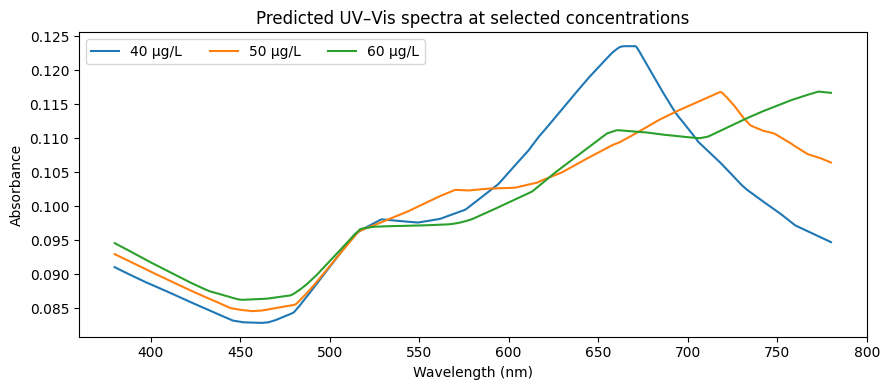

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Tunables
GRID_CSV = "/content/drive/MyDrive/ArsenicSTS/uvvis_pred_grid_raw.csv"
CONCS_TO_PLOT = [40, 50, 60]  # µg/L
VISIBLE_ONLY = True  # set False to show full 200–800 nm

# Load grid (wide format: Wavelength, 0, 0.5, 1, ..., 60)
df = pd.read_csv(GRID_CSV)
df.columns = df.columns.map(str).str.strip()
df["Wavelength"] = pd.to_numeric(df["Wavelength"], errors="coerce")

# Visible filter
if VISIBLE_ONLY:
    df = df[(df["Wavelength"] >= 380) & (df["Wavelength"] <= 780)]

# Helper to match column names exactly as saved
def col_name(c):
    return str(int(c)) if float(c).is_integer() else str(c)

# Plot
plt.figure(figsize=(9, 4))
for c in CONCS_TO_PLOT:
    col = col_name(c)
    if col not in df.columns:
        print(f"Warning: concentration column '{col}' not found in {GRID_CSV}")
        continue
    plt.plot(df["Wavelength"].values, df[col].values, label=f"{c} µg/L")

plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title("Predicted UV–Vis spectra at selected concentrations")
plt.legend(ncol=3)
plt.tight_layout()
plt.show()


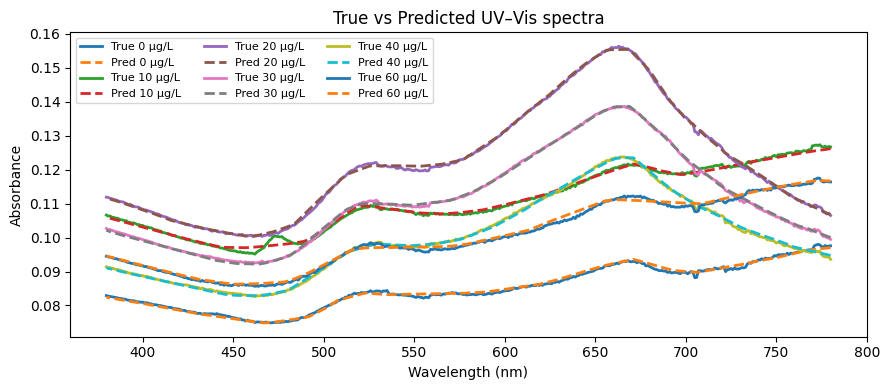

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Tunables
RAW_CSV = "/content/drive/MyDrive/ArsenicSTS/uvvis_predictions_raw.csv"
CONCS_TO_PLOT = [0, 10, 20, 30, 40, 60]  # µg/L
VISIBLE_ONLY = True

# Load and optionally restrict to visible range
df = pd.read_csv(RAW_CSV)
if VISIBLE_ONLY:
    df = df[(df["Wavelength"] >= 380) & (df["Wavelength"] <= 780)]

# Plot all chosen concentrations
plt.figure(figsize=(9, 4))
for c in CONCS_TO_PLOT:
    sub = df[df["Concentration"] == c]
    if sub.empty:
        print(f"Warning: no data for concentration {c}")
        continue
    wl = sub["Wavelength"].values
    A_true = sub["Absorbance_True"].values
    A_pred = sub["Absorbance_Pred"].values

    # True in solid line, predicted in dashed line
    plt.plot(wl, A_true, label=f"True {c} µg/L", lw=2)
    plt.plot(wl, A_pred, "--", label=f"Pred {c} µg/L", lw=2)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title("True vs Predicted UV–Vis spectra")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()


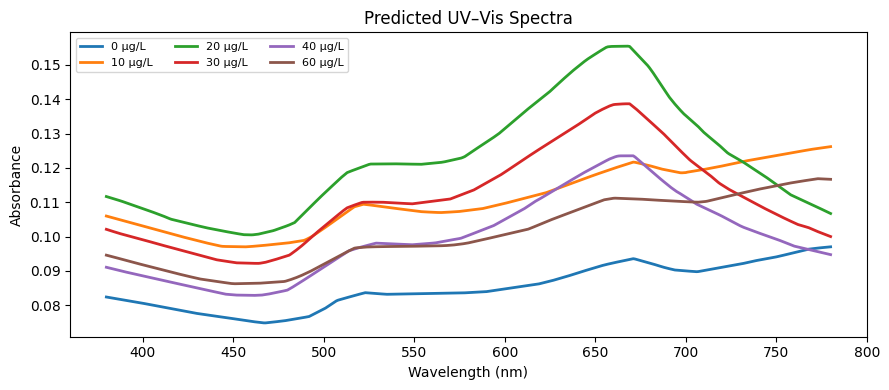

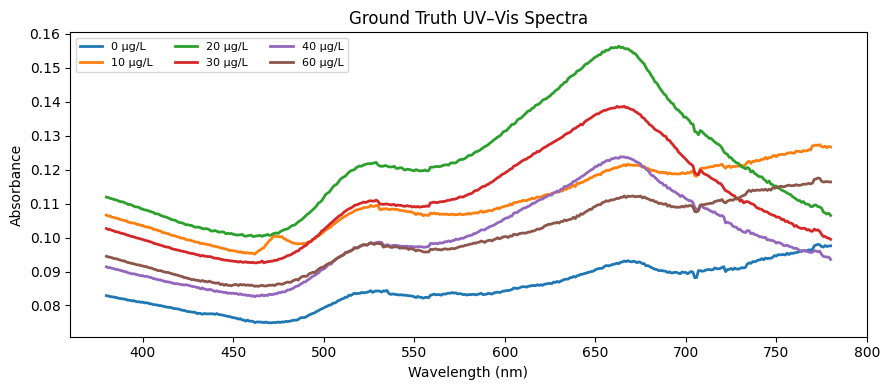

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Tunables
RAW_CSV = "/content/drive/MyDrive/ArsenicSTS/uvvis_predictions_raw.csv"
CONCS_TO_PLOT = [0, 10, 20, 30, 40, 60]  # µg/L
VISIBLE_ONLY = True

# Load and optionally restrict to visible range
df = pd.read_csv(RAW_CSV)
if VISIBLE_ONLY:
    df = df[(df["Wavelength"] >= 380) & (df["Wavelength"] <= 780)]

# --- Plot 1: Predicted spectra ---
plt.figure(figsize=(9, 4))
for c in CONCS_TO_PLOT:
    sub = df[df["Concentration"] == c]
    if sub.empty:
        print(f"Warning: no data for concentration {c}")
        continue
    wl = sub["Wavelength"].values
    A_pred = sub["Absorbance_Pred"].values
    plt.plot(wl, A_pred, label=f"{c} µg/L", lw=2)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title("Predicted UV–Vis Spectra")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

# --- Plot 2: Ground-truth spectra ---
plt.figure(figsize=(9, 4))
for c in CONCS_TO_PLOT:
    sub = df[df["Concentration"] == c]
    if sub.empty:
        continue
    wl = sub["Wavelength"].values
    A_true = sub["Absorbance_True"].values
    plt.plot(wl, A_true, label=f"{c} µg/L", lw=2)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title("Ground Truth UV–Vis Spectra")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()


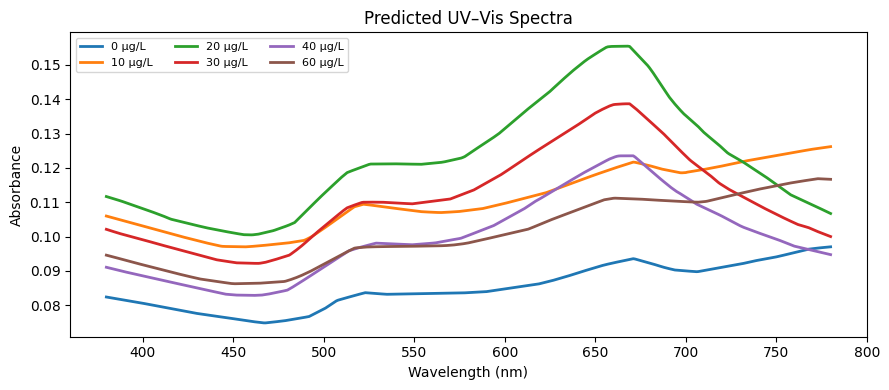

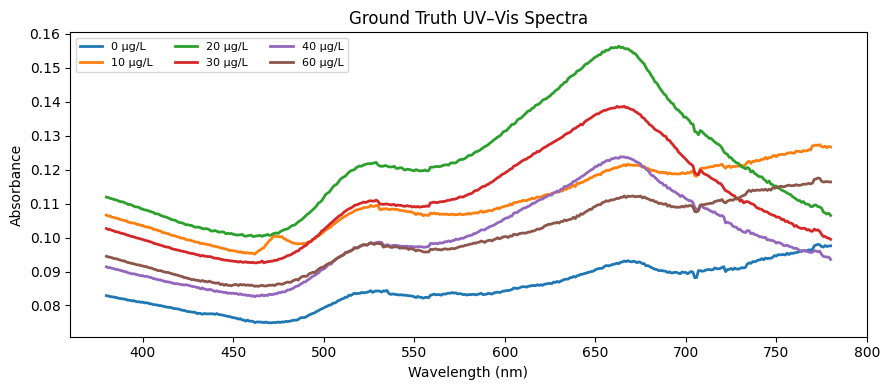

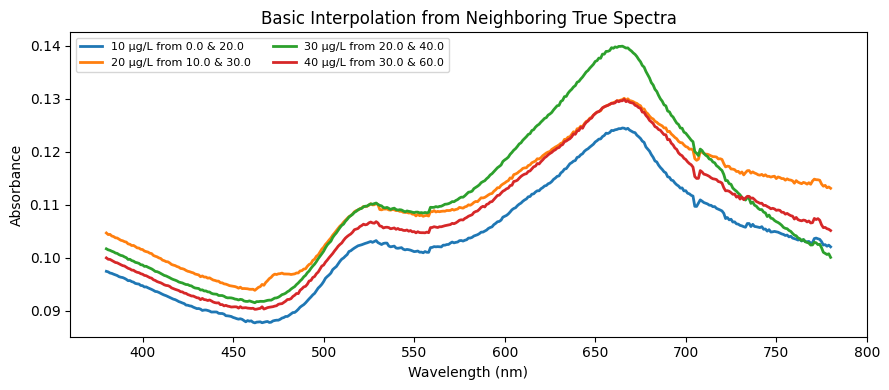

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Tunables
RAW_CSV = "/content/drive/MyDrive/ArsenicSTS/uvvis_predictions_raw.csv"
CONCS_TO_PLOT = [0, 10, 20, 30, 40, 60]  # µg/L
VISIBLE_ONLY = True

# Load and optionally restrict to visible range
df = pd.read_csv(RAW_CSV)
if VISIBLE_ONLY:
    df = df[(df["Wavelength"] >= 380) & (df["Wavelength"] <= 780)]

# --- Plot 1: Predicted spectra ---
plt.figure(figsize=(9, 4))
for c in CONCS_TO_PLOT:
    sub = df[df["Concentration"] == c]
    if sub.empty:
        print(f"Warning: no data for concentration {c}")
        continue
    wl = sub["Wavelength"].values
    A_pred = sub["Absorbance_Pred"].values
    plt.plot(wl, A_pred, label=f"{c} µg/L", lw=2)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title("Predicted UV–Vis Spectra")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

# --- Plot 2: Ground-truth spectra ---
plt.figure(figsize=(9, 4))
for c in CONCS_TO_PLOT:
    sub = df[df["Concentration"] == c]
    if sub.empty:
        continue
    wl = sub["Wavelength"].values
    A_true = sub["Absorbance_True"].values
    plt.plot(wl, A_true, label=f"{c} µg/L", lw=2)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title("Ground Truth UV–Vis Spectra")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

# --- Plot 3: Simple neighbor interpolation (ground-truth only) ---
# For each interior concentration, linearly interpolate its spectrum from the nearest lower and higher
# ground-truth concentrations (e.g., 10 from 0 and 20, 20 from 10 and 30, etc.)
available_concs = np.array(sorted(df["Concentration"].unique()))
plt.figure(figsize=(9, 4))

for c in CONCS_TO_PLOT[1:-1]:  # exclude endpoints 0 and 60
    # find neighbors in the available set
    idx = np.where(available_concs == c)[0]
    if len(idx) == 0:
        print(f"Warning: {c} not found in data, skipping.")
        continue
    i = idx[0]
    if i == 0 or i == len(available_concs) - 1:
        # skip if no both-side neighbors
        continue
    c0, c1 = available_concs[i-1], available_concs[i+1]

    s0 = df[df["Concentration"] == c0].sort_values("Wavelength")
    s1 = df[df["Concentration"] == c1].sort_values("Wavelength")
    st = df[df["Concentration"] == c].sort_values("Wavelength")  # just to get wavelength grid

    wl = st["Wavelength"].values
    A0 = s0["Absorbance_True"].values
    A1 = s1["Absorbance_True"].values

    # linear interpolation weight
    w = (c - c0) / (c1 - c0 + 1e-12)
    A_lin = (1 - w) * A0 + w * A1

    plt.plot(wl, A_lin, label=f"{c} µg/L from {c0} & {c1}", lw=2)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title("Basic Interpolation from Neighboring True Spectra")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()


#Comparison LOCO vs regular

[500] loss=3.1400e-01 rec=3.1335e-01 cal=5.2660e-04 rmean=2.3805e-03
[1000] loss=3.7878e-01 rec=3.7790e-01 cal=2.5633e-03 rmean=5.5015e-04
[1500] loss=1.6966e-01 rec=1.6955e-01 cal=6.2955e-05 rmean=4.6060e-04
[2000] loss=1.9176e-01 rec=1.9147e-01 cal=6.1263e-04 rmean=5.0059e-04
[2500] loss=3.8565e-01 rec=3.8556e-01 cal=2.6378e-05 rmean=3.7272e-04
[3000] loss=2.8912e-01 rec=2.8903e-01 cal=1.4411e-05 rmean=4.1838e-04
Best at step 880  loss=9.0637e-02
[500] loss=2.6147e-01 rec=2.6050e-01 cal=8.4442e-04 rmean=3.4957e-03
[1000] loss=1.8335e-01 rec=1.8240e-01 cal=9.2035e-04 rmean=3.3475e-03
[1500] loss=1.8547e-01 rec=1.8343e-01 cal=3.1045e-04 rmean=9.7184e-03
[2000] loss=1.6881e-01 rec=1.6684e-01 cal=1.4022e-04 rmean=9.5919e-03
[2500] loss=2.6241e-01 rec=2.6093e-01 cal=5.6616e-05 rmean=7.3106e-03
[3000] loss=2.6428e-01 rec=2.6346e-01 cal=2.7844e-05 rmean=4.0614e-03
Best at step 2077  loss=6.9829e-02


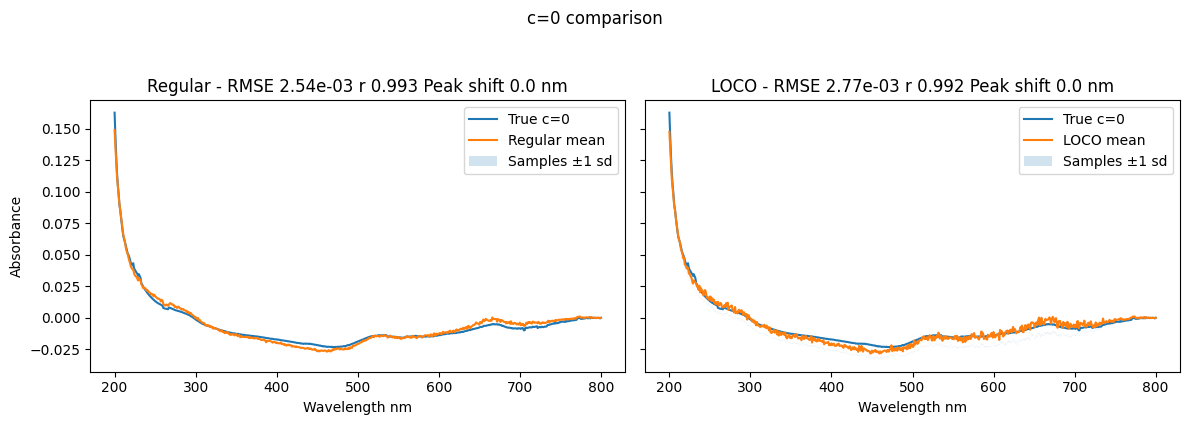

[500] loss=2.8592e-01 rec=2.8539e-01 cal=5.5735e-04 rmean=1.7357e-03
[1000] loss=2.1453e-01 rec=2.1334e-01 cal=3.6855e-03 rmean=3.6723e-04
[1500] loss=2.2125e-01 rec=2.2113e-01 cal=1.6508e-04 rmean=3.4453e-04
[2000] loss=2.6302e-01 rec=2.6293e-01 cal=1.7406e-04 rmean=1.9821e-04
[2500] loss=2.1090e-01 rec=2.1084e-01 cal=5.8877e-05 rmean=1.9729e-04
[3000] loss=2.7120e-01 rec=2.7113e-01 cal=5.5128e-05 rmean=2.3374e-04
Best at step 2527  loss=9.4945e-02
[500] loss=2.2896e-01 rec=2.2803e-01 cal=6.9526e-04 rmean=3.5866e-03
[1000] loss=1.4458e-01 rec=1.4386e-01 cal=7.0267e-04 rmean=2.4946e-03
[1500] loss=1.8452e-01 rec=1.8422e-01 cal=1.2961e-04 rmean=1.2818e-03
[2000] loss=2.2017e-01 rec=2.1992e-01 cal=1.2296e-04 rmean=1.0604e-03
[2500] loss=1.7555e-01 rec=1.7542e-01 cal=3.2481e-05 rmean=5.9105e-04
[3000] loss=1.4512e-01 rec=1.4497e-01 cal=1.3038e-05 rmean=7.0042e-04
Best at step 2470  loss=5.5199e-02


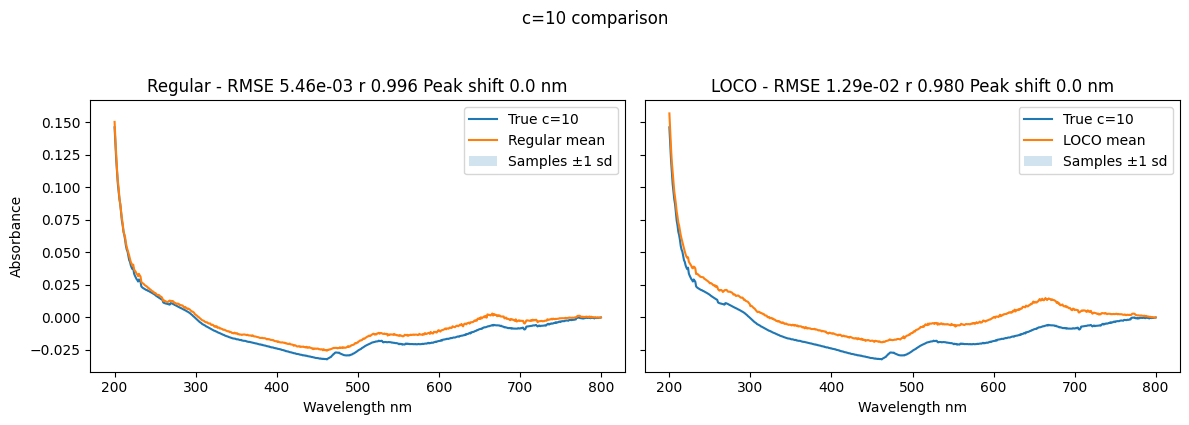

[500] loss=3.0996e-01 rec=3.0969e-01 cal=1.4592e-04 rmean=1.0516e-03
[1000] loss=1.6077e-01 rec=1.6041e-01 cal=9.6827e-04 rmean=3.2512e-04
[1500] loss=2.0304e-01 rec=2.0292e-01 cal=1.8141e-04 rmean=2.7375e-04
[2000] loss=1.9584e-01 rec=1.9579e-01 cal=3.3971e-05 rmean=2.0931e-04
[2500] loss=2.2819e-01 rec=2.2812e-01 cal=5.8354e-05 rmean=2.6530e-04
[3000] loss=2.6081e-01 rec=2.6074e-01 cal=2.5375e-05 rmean=2.8034e-04
Best at step 2116  loss=1.0415e-01
[500] loss=1.8150e-01 rec=1.8065e-01 cal=1.7354e-03 rmean=1.5613e-03
[1000] loss=1.1933e-01 rec=1.1879e-01 cal=1.0608e-03 rmean=1.0928e-03
[1500] loss=1.5181e-01 rec=1.5099e-01 cal=4.2558e-04 rmean=3.4383e-03
[2000] loss=2.1135e-01 rec=2.1069e-01 cal=2.8938e-05 rmean=3.2639e-03
[2500] loss=3.0123e-01 rec=3.0035e-01 cal=1.7721e-05 rmean=4.3465e-03
[3000] loss=1.0390e-01 rec=1.0291e-01 cal=1.1035e-05 rmean=4.9114e-03
Best at step 2288  loss=7.3576e-02


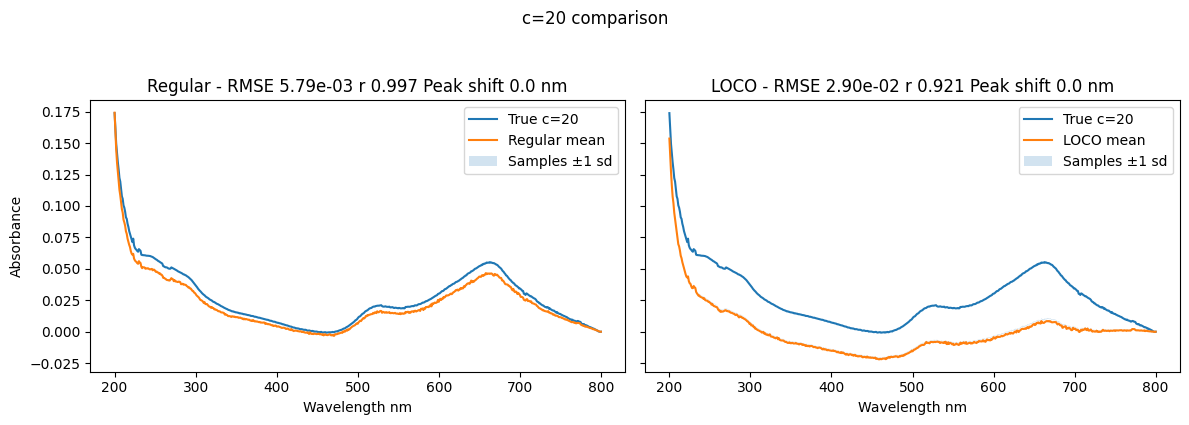

[500] loss=2.8106e-01 rec=2.8062e-01 cal=8.7901e-04 rmean=8.4949e-04
[1000] loss=1.6827e-01 rec=1.6797e-01 cal=8.0973e-04 rmean=2.7806e-04
[1500] loss=3.3888e-01 rec=3.3877e-01 cal=2.4245e-04 rmean=1.9369e-04
[2000] loss=2.5777e-01 rec=2.5771e-01 cal=8.0574e-05 rmean=1.6918e-04
[2500] loss=2.6730e-01 rec=2.6725e-01 cal=3.7415e-05 rmean=1.5690e-04
[3000] loss=1.2073e-01 rec=1.2069e-01 cal=2.5464e-05 rmean=1.5912e-04
Best at step 936  loss=9.7281e-02
[500] loss=2.3108e-01 rec=2.3081e-01 cal=1.5758e-04 rmean=9.8877e-04
[1000] loss=2.8882e-01 rec=2.8866e-01 cal=2.2555e-04 rmean=3.9725e-04
[1500] loss=2.0401e-01 rec=2.0369e-01 cal=7.8754e-04 rmean=3.5957e-04
[2000] loss=3.1274e-01 rec=3.1265e-01 cal=5.2035e-05 rmean=3.2410e-04
[2500] loss=2.0643e-01 rec=2.0636e-01 cal=3.1267e-05 rmean=2.8807e-04
[3000] loss=3.3134e-01 rec=3.3127e-01 cal=3.6775e-05 rmean=2.7060e-04
Best at step 2987  loss=1.1568e-01


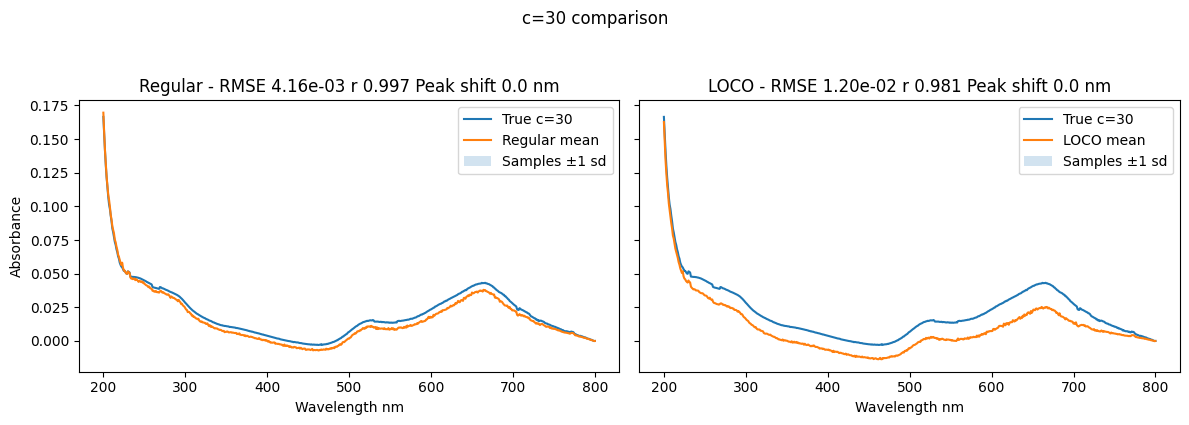

[500] loss=2.8990e-01 rec=2.8939e-01 cal=6.3380e-04 rmean=1.5150e-03
[1000] loss=3.8497e-01 rec=3.8474e-01 cal=4.4666e-04 rmean=4.1107e-04
[1500] loss=2.0363e-01 rec=2.0335e-01 cal=7.4600e-04 rmean=2.9511e-04
[2000] loss=2.5155e-01 rec=2.5149e-01 cal=6.3755e-05 rmean=1.8754e-04
[2500] loss=1.3914e-01 rec=1.3909e-01 cal=3.9738e-05 rmean=1.6763e-04
[3000] loss=1.5128e-01 rec=1.5122e-01 cal=3.3073e-05 rmean=1.9323e-04
Best at step 1742  loss=1.0519e-01
[500] loss=2.7574e-01 rec=2.7533e-01 cal=5.8619e-04 rmean=1.1473e-03
[1000] loss=3.0113e-01 rec=3.0063e-01 cal=1.0103e-03 rmean=9.3282e-04
[1500] loss=2.8940e-01 rec=2.8908e-01 cal=1.5974e-04 rmean=1.3363e-03
[2000] loss=2.4044e-01 rec=2.4006e-01 cal=1.0826e-04 rmean=1.7410e-03
[2500] loss=2.3986e-01 rec=2.3949e-01 cal=5.2019e-05 rmean=1.7497e-03
[3000] loss=3.2843e-01 rec=3.2822e-01 cal=3.8760e-05 rmean=9.8713e-04
Best at step 2429  loss=8.4553e-02


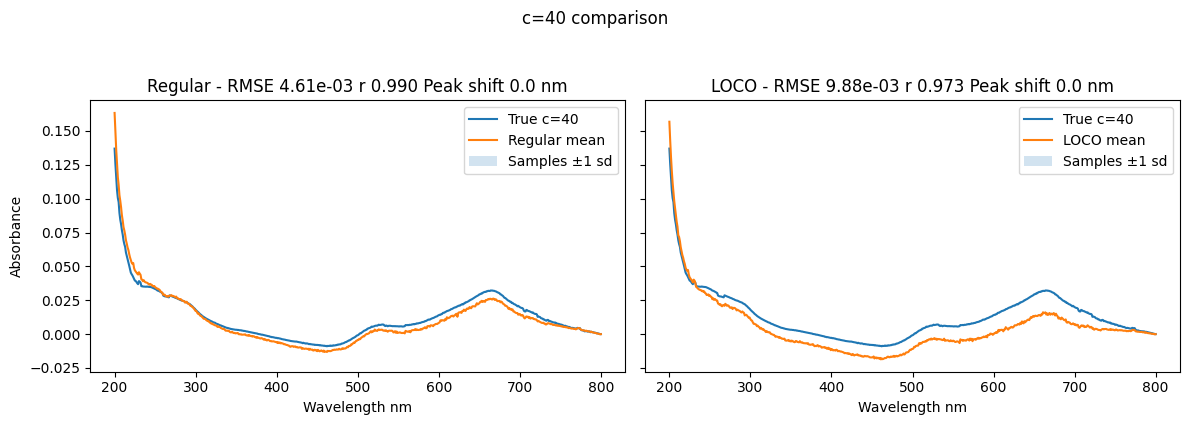

[500] loss=1.2480e-01 rec=1.2425e-01 cal=3.4643e-04 rmean=2.1805e-03
[1000] loss=2.5996e-01 rec=2.5953e-01 cal=5.6616e-04 rmean=1.2741e-03
[1500] loss=1.9616e-01 rec=1.9551e-01 cal=1.2487e-04 rmean=2.9807e-03
[2000] loss=2.4494e-01 rec=2.4399e-01 cal=7.6117e-05 rmean=4.5711e-03
[2500] loss=1.7893e-01 rec=1.7755e-01 cal=6.0260e-05 rmean=6.7944e-03
[3000] loss=2.8827e-01 rec=2.8599e-01 cal=4.9208e-05 rmean=1.1297e-02
Best at step 1995  loss=8.6656e-02
[500] loss=1.8072e-01 rec=1.8026e-01 cal=1.1322e-03 rmean=5.4837e-04
[1000] loss=1.7886e-01 rec=1.7875e-01 cal=1.5736e-04 rmean=3.0414e-04
[1500] loss=1.4532e-01 rec=1.4516e-01 cal=3.9685e-04 rmean=2.1942e-04
[2000] loss=2.6205e-01 rec=2.6199e-01 cal=6.9387e-05 rmean=1.7260e-04
[2500] loss=2.0733e-01 rec=2.0726e-01 cal=8.5768e-05 rmean=2.1488e-04
[3000] loss=2.1878e-01 rec=2.1871e-01 cal=5.4533e-05 rmean=2.3165e-04
Best at step 2636  loss=7.2569e-02


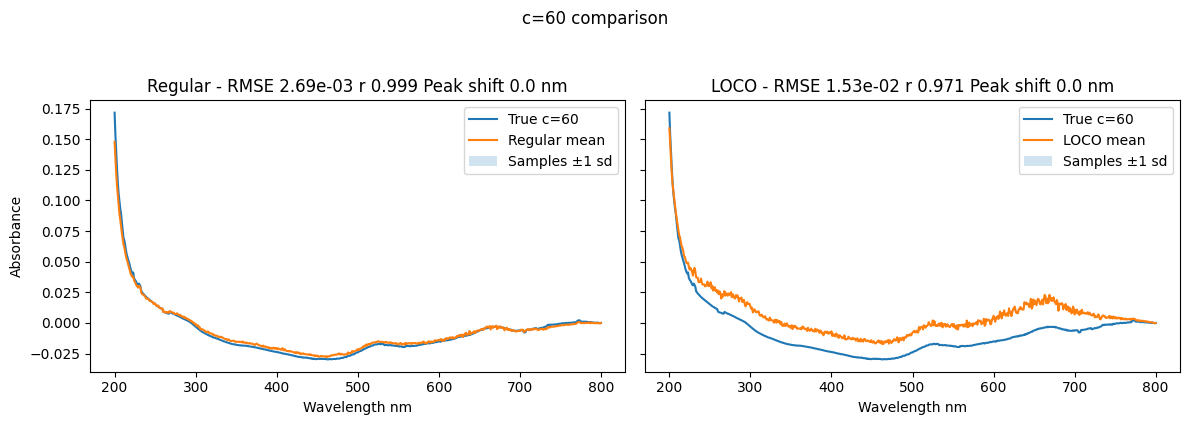

Saved summary to /content/drive/MyDrive/ArsenicSTS/mr_loco_vs_regular.csv
      c   in_rmse  loco_rmse      in_r    loco_r  in_peak_shift  \
0   0.0  0.002536   0.002773  0.992722  0.991513            0.0   
1  10.0  0.005456   0.012944  0.995816  0.979733            0.0   
2  20.0  0.005793   0.029030  0.997405  0.921259            0.0   
3  30.0  0.004161   0.011972  0.996602  0.980786            0.0   
4  40.0  0.004609   0.009881  0.990081  0.972853            0.0   
5  60.0  0.002688   0.015273  0.998809  0.970845            0.0   

   loco_peak_shift                                                fig  
0              0.0  /content/drive/MyDrive/ArsenicSTS/figs_mr/comp...  
1              0.0  /content/drive/MyDrive/ArsenicSTS/figs_mr/comp...  
2              0.0  /content/drive/MyDrive/ArsenicSTS/figs_mr/comp...  
3              0.0  /content/drive/MyDrive/ArsenicSTS/figs_mr/comp...  
4              0.0  /content/drive/MyDrive/ArsenicSTS/figs_mr/comp...  
5              0.0  /con

In [ ]:
# Optional
# !pip -q install torch torchvision torchaudio

import os, math, time, random, json, pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Repro
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.set_float32_matmul_precision("medium")
except Exception:
    pass
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
ROOT = "/content/drive/MyDrive/ArsenicSTS"
DATA_CSV = f"{ROOT}/UVVisData/0.30MB_AuNP_As.csv"
CKPT_DIR = f"{ROOT}/mean_residual_ckpt"
FIG_ROOT = f"{ROOT}/figs_mr"
GEN_ROOT = f"{ROOT}/generated_mr"
os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(FIG_ROOT, exist_ok=True)
os.makedirs(GEN_ROOT, exist_ok=True)

# ===== Data loader and preprocessing =====
def load_uvvis_csv(path, baseline_correct=True):
    df = pd.read_csv(path)
    df.columns = [str(c).strip() for c in df.columns]
    assert "Wavelength" in df.columns, "CSV must have 'Wavelength'"
    wl = df["Wavelength"].to_numpy().astype(np.float32)

    conc_cols = []
    for c in df.columns:
        if c == "Wavelength": continue
        try:
            float(c); conc_cols.append(c)
        except: pass

    conc_vals = np.array(sorted([float(c) for c in conc_cols], key=float), dtype=np.float32)
    conc_cols_sorted = [str(int(c)) if float(c).is_integer() else str(c) for c in conc_vals]
    A = np.stack([df[c].to_numpy().astype(np.float32) for c in conc_cols_sorted], axis=1)  # [601,6]

    if baseline_correct:
        idx_800 = int(np.argmin(np.abs(wl - 800.0)))
        base = A[idx_800:idx_800+1, :]
        A = A - base
    return wl, conc_vals, A

wl, concs_all, A = load_uvvis_csv(DATA_CSV, baseline_correct=True)
assert A.shape[0] == 601 and A.shape[1] == len(concs_all)
SPECTRA = {float(c): A[:, i].astype(np.float32) for i, c in enumerate(concs_all)}
C_MIN, C_MAX = float(concs_all.min()), float(concs_all.max())

def scale_c(c): return (c - C_MIN) / (C_MAX - C_MIN + 1e-12)
def unscale_c(cs): return cs * (C_MAX - C_MIN) + C_MIN

class SpectraScaler:
    def __init__(self): self.mean=None; self.std=None
    def fit(self, X):
        self.mean = X.mean(axis=0, keepdims=True)
        self.std = X.std(axis=0, keepdims=True) + 1e-6
    def transform(self, X): return (X - self.mean) / self.std
    def inverse(self, Xz): return Xz * self.std + self.mean
    def save(self, path):
        with open(path,"wb") as f: pickle.dump({"mean":self.mean,"std":self.std}, f)
    @staticmethod
    def load(path):
        with open(path,"rb") as f: d=pickle.load(f)
        sc=SpectraScaler(); sc.mean=d["mean"]; sc.std=d["std"]; return sc

# Fit scaler on all six real spectra
X_real = np.stack([SPECTRA[float(c)] for c in concs_all], axis=0)
GLOBAL_SCALER = SpectraScaler(); GLOBAL_SCALER.fit(X_real)
Xz_real = GLOBAL_SCALER.transform(X_real).astype(np.float32)

# ===== Training pool switch for LOCO vs regular =====
XZ_POOL = Xz_real.copy()
CONCS_POOL = concs_all.copy()

def set_train_pool(concs_keep):
    global XZ_POOL, CONCS_POOL
    keep_idx = [list(concs_all).index(float(c)) for c in concs_keep]
    XZ_POOL = Xz_real[keep_idx]
    CONCS_POOL = concs_all[keep_idx]

# ===== Mixup sampler over concentrations using the current pool =====
def mixup_batch(batch_size=64, amp_noise=0.0, warp_nm=0.0):
    n = len(CONCS_POOL)
    i = np.random.randint(0, n, size=(batch_size,))
    j = np.random.randint(0, n, size=(batch_size,))
    a = np.random.beta(0.5, 0.5, size=(batch_size,1)).astype(np.float32)

    xi = XZ_POOL[i]
    xj = XZ_POOL[j]
    ci = CONCS_POOL[i].reshape(-1,1).astype(np.float32)
    cj = CONCS_POOL[j].reshape(-1,1).astype(np.float32)

    x = a*xi + (1-a)*xj
    c = a*ci + (1-a)*cj

    if amp_noise > 0:
        x = x + np.random.normal(0.0, amp_noise, size=x.shape).astype(np.float32)

    # tiny wavelength warp by rolling a few bins
    if warp_nm > 0:
        step_nm = float(np.mean(np.diff(wl)))
        max_shift = int(np.floor(warp_nm / max(step_nm, 1e-12)))
        if max_shift >= 1:
            shifts = np.random.randint(-max_shift, max_shift + 1, size=(batch_size,))
            for b, s in enumerate(shifts):
                if s != 0:
                    x[b] = np.roll(x[b], int(s))

    c01 = scale_c(c)
    xb = torch.from_numpy(x).to(DEVICE)
    cb = torch.from_numpy(c01).to(DEVICE)
    return xb, cb  # xb [B,601] z-scored, cb [B,1] in 0..1

# ===== Model: μ(c) + r(c, z) with FiLM conditioning and calibration head =====
class FiLMLayer(nn.Module):
    def __init__(self, cond_dim, hidden_dim):
        super().__init__()
        self.to_gamma = nn.Linear(cond_dim, hidden_dim)
        self.to_beta  = nn.Linear(cond_dim, hidden_dim)
    def forward(self, h, cond):
        gamma = self.to_gamma(cond)
        beta  = self.to_beta(cond)
        return h * (1 + gamma) + beta

class MeanNet(nn.Module):
    # c in 0..1 -> μ in R^601
    def __init__(self, c_dim=1, hidden=128, layers=3, out_dim=601):
        super().__init__()
        dims = [c_dim] + [hidden]*layers + [out_dim]
        self.f = []
        for i in range(len(dims)-2):
            self.f += [nn.Linear(dims[i], dims[i+1]), nn.SiLU(), nn.LayerNorm(dims[i+1])]
        self.f += [nn.Linear(dims[-2], dims[-1])]
        self.f = nn.Sequential(*self.f)
    def forward(self, c01):
        return self.f(c01)

class ResidualNet(nn.Module):
    # (z, c) -> residual r in R^601, FiLM from c
    def __init__(self, z_dim=4, c_dim=1, c_emb=32, hidden=256, layers=3, out_dim=601):
        super().__init__()
        self.c_embed = nn.Sequential(nn.Linear(c_dim, c_emb), nn.SiLU())
        self.inp = nn.Linear(z_dim, hidden)
        self.blocks = nn.ModuleList([nn.Sequential(nn.LayerNorm(hidden), nn.SiLU(), nn.Linear(hidden, hidden)) for _ in range(layers)])
        self.films  = nn.ModuleList([FiLMLayer(c_emb, hidden) for _ in range(layers)])
        self.out = nn.Linear(hidden, out_dim)
    def forward(self, z, c01):
        ce = self.c_embed(c01)
        h = self.inp(z)
        for blk, film in zip(self.blocks, self.films):
            h = blk(h)
            h = film(h, ce)
        r = self.out(h)
        return r

class CalibHead(nn.Module):
    # predict c from spectrum in z-scored space
    def __init__(self, in_dim=601):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(in_dim, 256), nn.SiLU(),
            nn.Linear(256, 64), nn.SiLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.f(x)

class MeanResidualModel(nn.Module):
    def __init__(self, z_dim=4):
        super().__init__()
        self.mean = MeanNet()
        self.res  = ResidualNet(z_dim=z_dim)
        self.cal  = CalibHead()
        self.z_dim = z_dim
    def forward_multi(self, c01, K=4):
        # returns μ, r_all, r_mean, x_mean in z-scored space using K noise samples per item
        B = c01.size(0)
        mu = self.mean(c01)                                 # [B,601]
        z  = torch.randn(B, K, self.z_dim, device=c01.device)
        c_rep = c01.unsqueeze(1).repeat(1, K, 1)            # [B,K,1]
        r = self.res(z.view(B*K, -1), c_rep.view(B*K, -1))  # [B*K,601]
        r = r.view(B, K, -1)
        r_mean = r.mean(dim=1)                              # [B,601]
        x_mean = mu + r_mean
        return mu, r, r_mean, x_mean

# ===== Losses and training =====
def second_deriv_loss(x, strength=1.0):
    d2 = x[:, 2:] - 2*x[:, 1:-1] + x[:, :-2]
    return strength * (d2.pow(2).mean())

def train_mean_residual(
    steps=4000, batch_size=64, K=6, lr=5e-4,
    w_rec=1.0, w_rmean=0.2, w_cal=0.3, w_smooth=1e-3,
    amp_noise=0.002, warp_nm=1.0, ckpt_dir=CKPT_DIR
):
    os.makedirs(ckpt_dir, exist_ok=True)
    model = MeanResidualModel(z_dim=4).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=steps, eta_min=1e-5)
    best = {"loss": 1e9, "step": 0}

    # save a scaler per run to be explicit
    scaler_path = os.path.join(ckpt_dir, "scaler.pkl")
    with open(scaler_path, "wb") as f:
        pickle.dump({"mean": GLOBAL_SCALER.mean, "std": GLOBAL_SCALER.std}, f)

    for step in range(1, steps+1):
        xb, cb = mixup_batch(batch_size=batch_size, amp_noise=amp_noise, warp_nm=warp_nm)  # xb in z-scored
        mu, r_all, r_mean, x_mean = model.forward_multi(cb, K=K)

        rec = F.mse_loss(x_mean, xb)
        rmean = r_mean.pow(2).mean()
        cal = F.mse_loss(model.cal(x_mean), cb)
        smooth = second_deriv_loss(mu)

        loss = w_rec*rec + w_rmean*rmean + w_cal*cal + w_smooth*smooth

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        sch.step()

        if loss.item() < best["loss"] - 1e-6:
            best = {"loss": float(loss.item()), "step": step}
            torch.save(model.state_dict(), os.path.join(ckpt_dir, "mr_model.pt"))

        if step % 500 == 0:
            print(f"[{step}] loss={loss.item():.4e} rec={rec.item():.4e} cal={cal.item():.4e} rmean={rmean.item():.4e}")

    print(f"Best at step {best['step']}  loss={best['loss']:.4e}")
    return model

def load_model(ckpt_dir):
    m = MeanResidualModel(z_dim=4).to(DEVICE)
    m.load_state_dict(torch.load(os.path.join(ckpt_dir, "mr_model.pt"), map_location=DEVICE))
    m.eval()
    sc = SpectraScaler.load(os.path.join(ckpt_dir, "scaler.pkl"))
    return m, sc

# ===== Inference helpers that use a passed scaler =====
@torch.no_grad()
def predict_mean_spectrum(model, scaler, c_target):
    c01 = torch.tensor([[scale_c(float(c_target))]], device=DEVICE).float()
    mu = model.mean(c01)[0].cpu().numpy()                 # z-scored
    x = scaler.inverse(mu[None, :])[0]
    return x

@torch.no_grad()
def sample_spectra(model, scaler, c_target, N=64):
    c01 = torch.full((N,1), fill_value=scale_c(float(c_target)), device=DEVICE).float()
    mu, r, r_mean, x_mean = model.forward_multi(c01, K=1)
    xhat = mu + r_mean
    x = scaler.inverse(xhat.cpu().numpy())
    return x

def rmse(a, b): a=np.asarray(a); b=np.asarray(b); return float(np.sqrt(np.mean((a-b)**2)))
def pearsonr(a, b):
    a=np.asarray(a); b=np.asarray(b)
    a=a-a.mean(); b=b-b.mean()
    return float((a*b).sum() / (np.sqrt((a*a).sum())*np.sqrt((b*b).sum())+1e-12))
def peak_nm(wl, y): return float(wl[int(np.argmax(y))])

# ===== Runner for one holdout that does both trainings and side-by-side plot =====
def train_and_compare_c_hold(c_hold, steps=4000):
    c_hold = float(c_hold)
    x_true = SPECTRA[c_hold]

    # A) Regular: keep all concentrations
    set_train_pool(concs_all)
    ckpt_full = os.path.join(CKPT_DIR, "full")
    model_full = train_mean_residual(steps=steps, ckpt_dir=ckpt_full)
    model_full, sc_full = load_model(ckpt_full)
    x_pred_full = predict_mean_spectrum(model_full, sc_full, c_hold)
    r_full = pearsonr(x_true, x_pred_full)
    e_full = rmse(x_true, x_pred_full)
    pshift_full = abs(peak_nm(wl, x_true) - peak_nm(wl, x_pred_full))

    # B) LOCO: drop c_hold
    concs_keep = [float(c) for c in concs_all if float(c) != c_hold]
    set_train_pool(concs_keep)
    ckpt_loco = os.path.join(CKPT_DIR, f"loco_c_{int(c_hold)}")
    model_loco = train_mean_residual(steps=steps, ckpt_dir=ckpt_loco)
    model_loco, sc_loco = load_model(ckpt_loco)
    x_pred_loco = predict_mean_spectrum(model_loco, sc_loco, c_hold)
    r_loco = pearsonr(x_true, x_pred_loco)
    e_loco = rmse(x_true, x_pred_loco)
    pshift_loco = abs(peak_nm(wl, x_true) - peak_nm(wl, x_pred_loco))

    # Side-by-side plot
    fig, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True)
    # Left: regular
    axs[0].plot(wl, x_true, label=f"True c={int(c_hold)}")
    axs[0].plot(wl, x_pred_full, label="Regular mean")
    Xs_full = sample_spectra(model_full, sc_full, c_hold, N=128)
    m_full, s_full = Xs_full.mean(axis=0), Xs_full.std(axis=0)
    axs[0].fill_between(wl, m_full - s_full, m_full + s_full, alpha=0.2, label="Samples ±1 sd")
    axs[0].set_title(f"Regular - RMSE {e_full:.2e} r {r_full:.3f} Peak shift {pshift_full:.1f} nm")
    axs[0].set_xlabel("Wavelength nm"); axs[0].set_ylabel("Absorbance"); axs[0].legend()

    # Right: LOCO
    axs[1].plot(wl, x_true, label=f"True c={int(c_hold)}")
    axs[1].plot(wl, x_pred_loco, label="LOCO mean")
    Xs_loco = sample_spectra(model_loco, sc_loco, c_hold, N=128)
    m_loco, s_loco = Xs_loco.mean(axis=0), Xs_loco.std(axis=0)
    axs[1].fill_between(wl, m_loco - s_loco, m_loco + s_loco, alpha=0.2, label="Samples ±1 sd")
    axs[1].set_title(f"LOCO - RMSE {e_loco:.2e} r {r_loco:.3f} Peak shift {pshift_loco:.1f} nm")
    axs[1].set_xlabel("Wavelength nm"); axs[1].legend()

    fig.suptitle(f"c={int(c_hold)} comparison", y=1.05)
    fig.tight_layout()
    outpng = os.path.join(FIG_ROOT, f"compare_c_{int(c_hold)}.png")
    plt.savefig(outpng, dpi=160); plt.show()

    return {
        "c": c_hold,
        "in_rmse": e_full, "in_r": r_full, "in_peak_shift": pshift_full,
        "loco_rmse": e_loco, "loco_r": r_loco, "loco_peak_shift": pshift_loco,
        "fig": outpng
    }

# ===== Run across all holdouts and save summary =====
all_rows = []
for c_hold in concs_all:
    res = train_and_compare_c_hold(float(c_hold), steps=3000)  # adjust steps for runtime
    all_rows.append(res)

df = pd.DataFrame(all_rows, columns=["c","in_rmse","loco_rmse","in_r","loco_r","in_peak_shift","loco_peak_shift","fig"])
out_csv = os.path.join(ROOT, "mr_loco_vs_regular.csv")
df.to_csv(out_csv, index=False)
print("Saved summary to", out_csv)
print(df)


In [ ]:
!pip install colour-science

/tmp/ipython-input-1984594021.py:150: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base_true = float(row800[col])
/tmp/ipython-input-1984594021.py:150: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base_true = float(row800[col])
/tmp/ipython-input-1984594021.py:150: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base_true = float(row800[col])
/tmp/ipython-input-1984594021.py:150: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base_true = float(row800[col])
/tmp/ipython-input-1984594021.py:150: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the fu

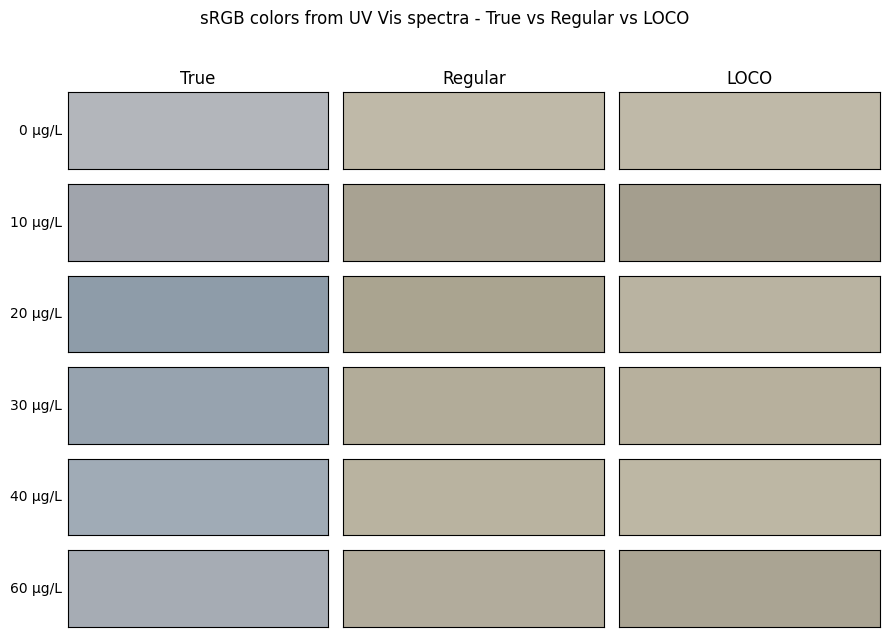

In [ ]:

import os, pickle, numpy as np, pandas as pd, torch, torch.nn as nn
import matplotlib.pyplot as plt
from colour import SpectralDistribution, sd_to_XYZ, XYZ_to_sRGB
from colour import MSDS_CMFS, SDS_ILLUMINANTS

# ----- Paths -----
ROOT = "/content/drive/MyDrive/ArsenicSTS"
DATA_CSV = f"{ROOT}/UVVisData/0.30MB_AuNP_As.csv"
CKPT_DIR = f"{ROOT}/mean_residual_ckpt"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Load data and utilities =====
df = pd.read_csv(DATA_CSV)
df.columns = df.columns.str.strip()
df["Wavelength"] = pd.to_numeric(df["Wavelength"], errors="coerce")

# true absorbance vector at 800 nm per column
row800 = df.loc[df["Wavelength"] == 800]
assert len(row800) == 1, "Expected an 800 nm row"

# Concentration columns (first 6 after Wavelength)
conc_cols = []
for c in df.columns:
    if c == "Wavelength": continue
    try:
        float(c); conc_cols.append(c)
    except:
        pass
# sort by numeric concentration
conc_cols = [str(int(x)) if float(x).is_integer() else str(x) for x in sorted(map(float, conc_cols))]
concs_all = np.array(list(map(float, conc_cols)), dtype=np.float32)

# Visible range
vis = df[(df.Wavelength >= 380) & (df.Wavelength <= 780)].copy()
wvl = vis.Wavelength.values.astype(float)

# Scale helpers consistent with training
C_MIN, C_MAX = float(concs_all.min()), float(concs_all.max())
def scale_c(c): return (c - C_MIN) / (C_MAX - C_MIN + 1e-12)

# ===== Model defs (match training) =====
class FiLMLayer(nn.Module):
    def __init__(self, cond_dim, hidden_dim):
        super().__init__()
        self.to_gamma = nn.Linear(cond_dim, hidden_dim)
        self.to_beta  = nn.Linear(cond_dim, hidden_dim)
    def forward(self, h, cond):
        return h * (1 + self.to_gamma(cond)) + self.to_beta(cond)

class MeanNet(nn.Module):
    def __init__(self, c_dim=1, hidden=128, layers=3, out_dim=601):
        super().__init__()
        dims = [c_dim] + [hidden]*layers + [out_dim]
        f = []
        for i in range(len(dims)-2):
            f += [nn.Linear(dims[i], dims[i+1]), nn.SiLU(), nn.LayerNorm(dims[i+1])]
        f += [nn.Linear(dims[-2], dims[-1])]
        self.f = nn.Sequential(*f)
    def forward(self, c01): return self.f(c01)

class ResidualNet(nn.Module):
    def __init__(self, z_dim=4, c_dim=1, c_emb=32, hidden=256, layers=3, out_dim=601):
        super().__init__()
        self.c_embed = nn.Sequential(nn.Linear(c_dim, c_emb), nn.SiLU())
        self.inp = nn.Linear(z_dim, hidden)
        self.blocks = nn.ModuleList([nn.Sequential(nn.LayerNorm(hidden), nn.SiLU(), nn.Linear(hidden, hidden)) for _ in range(layers)])
        self.films  = nn.ModuleList([FiLMLayer(c_emb, hidden) for _ in range(layers)])
        self.out = nn.Linear(hidden, out_dim)
    def forward(self, z, c01):
        ce = self.c_embed(c01)
        h = self.inp(z)
        for blk, film in zip(self.blocks, self.films):
            h = blk(h); h = film(h, ce)
        return self.out(h)

class CalibHead(nn.Module):
    def __init__(self, in_dim=601):
        super().__init__()
        self.f = nn.Sequential(nn.Linear(in_dim,256), nn.SiLU(), nn.Linear(256,64), nn.SiLU(), nn.Linear(64,1))
    def forward(self, x): return self.f(x)

class MeanResidualModel(nn.Module):
    def __init__(self, z_dim=4):
        super().__init__()
        self.mean = MeanNet()
        self.res  = ResidualNet(z_dim=z_dim)
        self.cal  = CalibHead()
    def forward_multi(self, c01, K=1):
        B = c01.size(0)
        mu = self.mean(c01)
        z  = torch.randn(B, K, 4, device=c01.device)
        c_rep = c01.unsqueeze(1).repeat(1, K, 1)
        r = self.res(z.view(B*K, -1), c_rep.view(B*K, -1)).view(B, K, -1).mean(1)
        return mu, r, mu + r

class SpectraScaler:
    def __init__(self): self.mean=None; self.std=None
    def inverse(self, Xz): return Xz * self.std + self.mean
    @staticmethod
    def load(path):
        with open(path,"rb") as f:
            d = pickle.load(f)
        sc = SpectraScaler()
        sc.mean = d["mean"]; sc.std = d["std"]
        return sc

def load_model_pair(ckpt_dir):
    m = MeanResidualModel().to(DEVICE)
    m.load_state_dict(torch.load(os.path.join(ckpt_dir, "mr_model.pt"), map_location=DEVICE))
    m.eval()
    sc = SpectraScaler.load(os.path.join(ckpt_dir, "scaler.pkl"))
    return m, sc

@torch.no_grad()
def predict_mean_spectrum(model, scaler, c_target):
    c01 = torch.tensor([[scale_c(float(c_target))]], device=DEVICE).float()
    mu = model.mean(c01)[0].cpu().numpy()               # z scored, baseline corrected
    x = scaler.inverse(mu[None,:])[0]                   # baseline corrected
    return x  # length 601, wavelengths 200..800 integer

# ===== Color conversion =====
cmfs       = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
illuminant = SDS_ILLUMINANTS['D65']

def spectrum_to_rgb(wavelengths_nm, absorbance):
    # Follow user’s recipe: double absorbance then convert to transmittance
    A2 = 4.0 * np.asarray(absorbance, dtype=float)
    T  = np.power(10.0, -A2)
    sd = SpectralDistribution(dict(zip(wavelengths_nm, T)))
    XYZ = sd_to_XYZ(sd, cmfs, illuminant) / 100.0
    rgb = np.clip(XYZ_to_sRGB(XYZ), 0, 1)
    return rgb

# ----- Load Regular model once -----
model_full, scaler_full = load_model_pair(os.path.join(CKPT_DIR, "full"))

# ===== Build color table: rows per concentration, columns = [True, Regular, LOCO] =====
labels = []
rgb_rows = []  # list of [rgb_true, rgb_full, rgb_loco]

for col in conc_cols:
    c_val = float(col)
    labels.append(f"{int(c_val) if c_val.is_integer() else c_val} µg/L")

    # True spectrum in visible range (no baseline correction)
    A_true_vis = vis[col].astype(float).values

    # Model mean predictions are baseline corrected. Add back the true 800 nm baseline to match absolute absorbance.
    base_true = float(row800[col])

    # Regular
    x_full = predict_mean_spectrum(model_full, scaler_full, c_val)           # len 601, 200..800
    # map to visible region indices: 380..780 inclusive -> indices 180..580
    idx0 = int(380 - 200); idx1 = int(780 - 200) + 1
    A_full_vis = x_full[idx0:idx1] + base_true

    # LOCO for this concentration
    loco_dir = os.path.join(CKPT_DIR, f"loco_c_{int(c_val)}")
    if not os.path.exists(os.path.join(loco_dir, "mr_model.pt")):
        # if LOCO not trained for this c, fall back to None color
        rgb_rows.append([spectrum_to_rgb(wvl, A_true_vis),
                         spectrum_to_rgb(wvl, A_full_vis),
                         np.array([0.2,0.2,0.2])])
        continue
    model_loco, scaler_loco = load_model_pair(loco_dir)
    x_loco = predict_mean_spectrum(model_loco, scaler_loco, c_val)
    A_loco_vis = x_loco[idx0:idx1] + base_true

    # Convert to colors
    rgb_true = spectrum_to_rgb(wvl, A_true_vis)
    rgb_full = spectrum_to_rgb(wvl, A_full_vis)
    rgb_loco = spectrum_to_rgb(wvl, A_loco_vis)
    rgb_rows.append([rgb_true, rgb_full, rgb_loco])

# ===== Plot grid: 6 rows x 3 cols =====
fig, axes = plt.subplots(len(rgb_rows), 3, figsize=(9, 2 + 0.7*len(rgb_rows)))
if len(rgb_rows) == 1:
    axes = np.array([axes])  # make 2D

for i, row in enumerate(rgb_rows):
    for j, rgb in enumerate(row):
        ax = axes[i, j]
        ax.add_patch(plt.Rectangle((0,0), 1,1, color=rgb))
        if i == 0:
            ax.set_title(["True","Regular","LOCO"][j])
        ax.set_xticks([]); ax.set_yticks([]); ax.set_xlim(0,1); ax.set_ylim(0,1)
    axes[i,0].set_ylabel(labels[i], rotation=0, ha="right", va="center")

fig.suptitle("sRGB colors from UV Vis spectra - True vs Regular vs LOCO", y=1.02)
plt.tight_layout()
plt.show()

#New

[500] loss=3.1454e-01 rec=3.1386e-01 cal=6.8197e-04 rmean=2.2903e-03
[1000] loss=3.8857e-01 rec=3.8800e-01 cal=1.5391e-03 rmean=5.1552e-04
[1500] loss=1.7010e-01 rec=1.6975e-01 cal=8.6284e-04 rmean=4.3220e-04
[2000] loss=1.9207e-01 rec=1.9180e-01 cal=6.6399e-04 rmean=3.4052e-04
[2500] loss=3.8095e-01 rec=3.8080e-01 cal=3.3340e-04 rmean=2.4075e-04
[3000] loss=2.8169e-01 rec=2.8139e-01 cal=7.9735e-04 rmean=2.4832e-04
[3500] loss=2.0734e-01 rec=2.0643e-01 cal=2.7898e-03 rmean=3.3442e-04
[4000] loss=1.7944e-01 rec=1.7936e-01 cal=3.1947e-05 rmean=2.9041e-04
[4500] loss=2.0171e-01 rec=2.0146e-01 cal=5.2638e-04 rmean=4.1959e-04
[5000] loss=3.7726e-01 rec=3.7714e-01 cal=2.6849e-05 rmean=4.9980e-04
[5500] loss=2.1033e-01 rec=2.1025e-01 cal=1.9024e-05 rmean=3.7998e-04
[6000] loss=1.6554e-01 rec=1.6543e-01 cal=1.4555e-05 rmean=5.0724e-04
Best at step 1257  loss=9.0613e-02


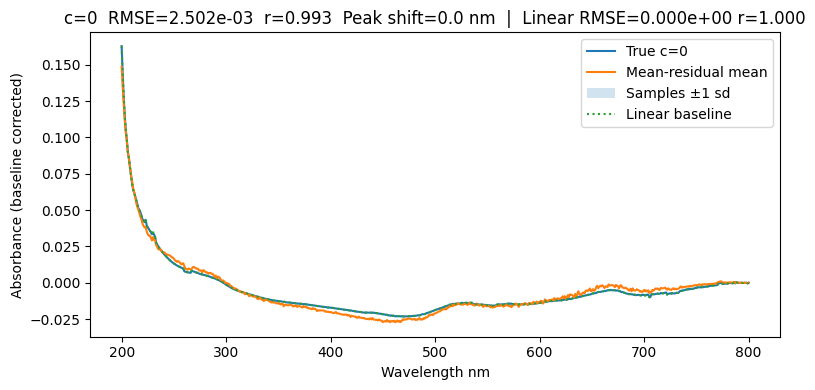

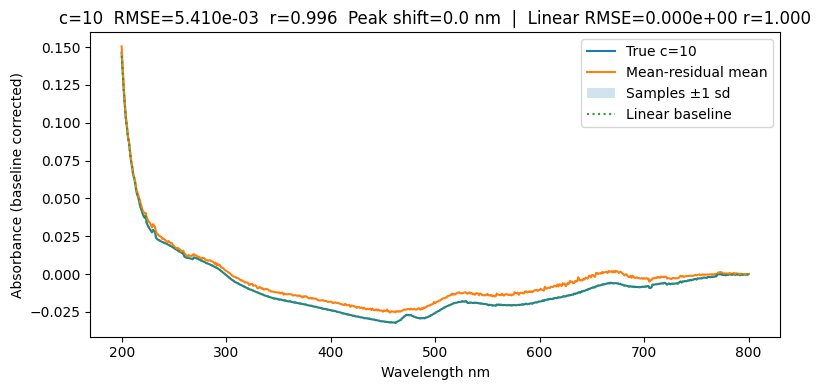

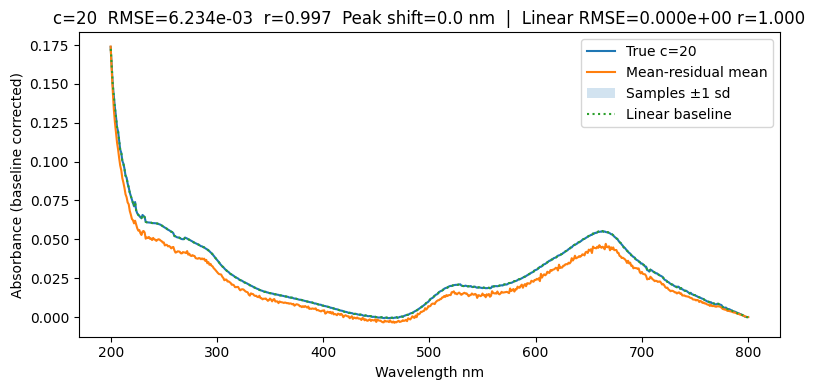

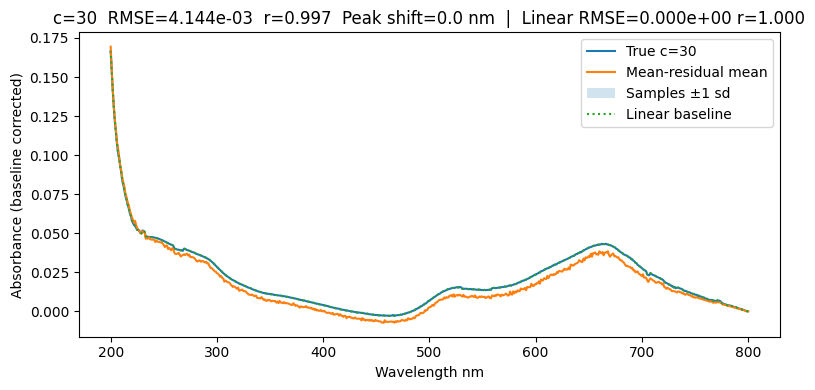

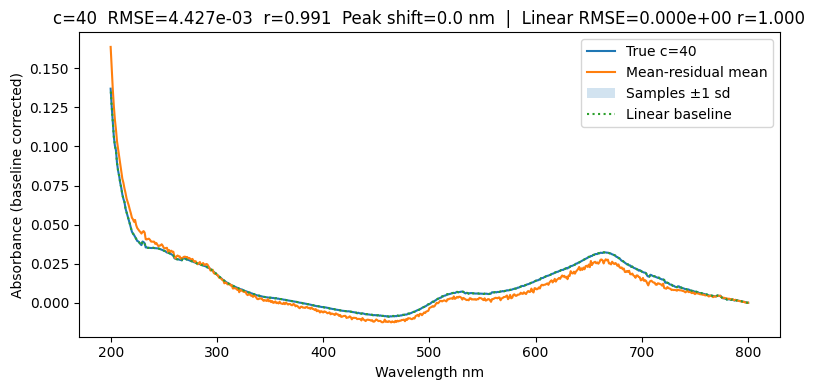

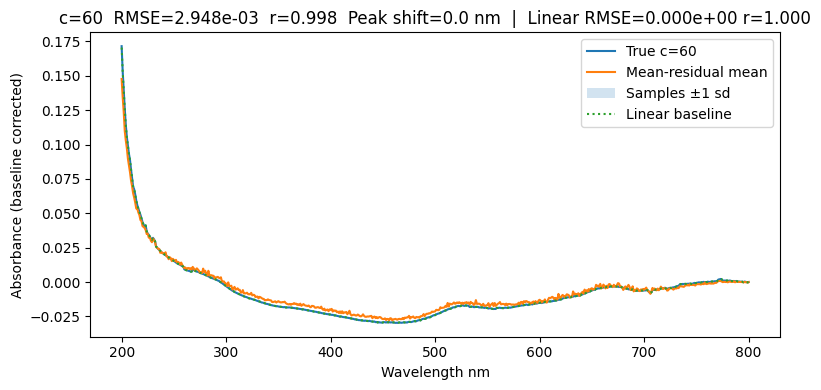

Saved metrics to /content/drive/MyDrive/ArsenicSTS/mr_results.csv


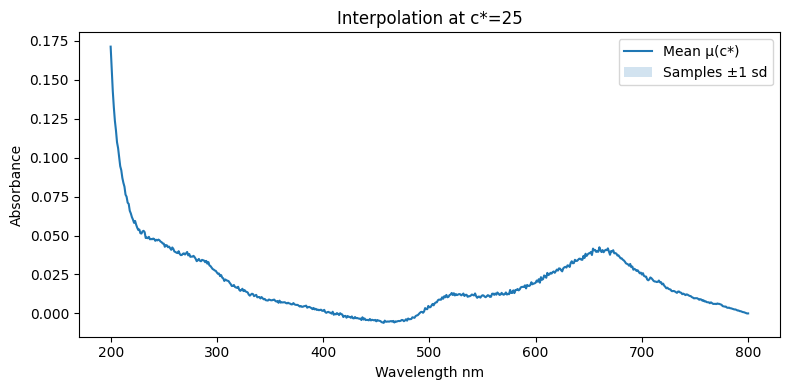

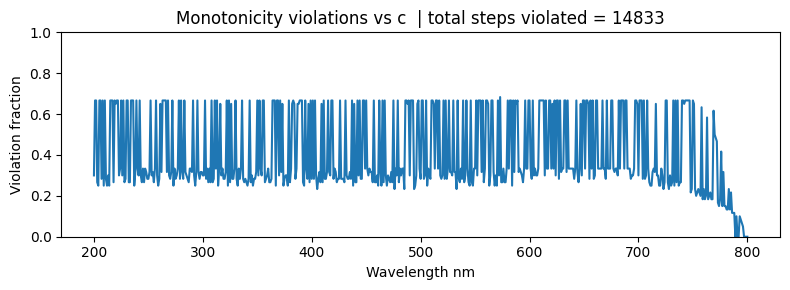

In [ ]:

# Optional pins
# !pip -q install torch torchvision torchaudio

import os, math, time, random, json, pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Repro
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.set_float32_matmul_precision("medium")
except Exception:
    pass
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
ROOT = "/content/drive/MyDrive/ArsenicSTS"
DATA_CSV = f"{ROOT}/UVVisData/0.30MB_AuNP_As.csv"
CKPT_DIR = f"{ROOT}/mean_residual_ckpt"
FIG_ROOT = f"{ROOT}/figs_mr"
GEN_ROOT = f"{ROOT}/generated_mr"
os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(FIG_ROOT, exist_ok=True)
os.makedirs(GEN_ROOT, exist_ok=True)

# ===== Data loader and preprocessing =====
def load_uvvis_csv(path, baseline_correct=True):
    df = pd.read_csv(path)
    df.columns = [str(c).strip() for c in df.columns]
    assert "Wavelength" in df.columns, "CSV must have 'Wavelength'"
    wl = df["Wavelength"].to_numpy().astype(np.float32)

    conc_cols = []
    for c in df.columns:
        if c == "Wavelength": continue
        try:
            float(c); conc_cols.append(c)
        except: pass

    conc_vals = np.array(sorted([float(c) for c in conc_cols], key=float), dtype=np.float32)
    conc_cols_sorted = [str(int(c)) if float(c).is_integer() else str(c) for c in conc_vals]
    A = np.stack([df[c].to_numpy().astype(np.float32) for c in conc_cols_sorted], axis=1)  # [601,6]

    if baseline_correct:
        idx_800 = int(np.argmin(np.abs(wl - 800.0)))
        base = A[idx_800:idx_800+1, :]
        A = A - base
    return wl, conc_vals, A

wl, concs_all, A = load_uvvis_csv(DATA_CSV, baseline_correct=True)
assert A.shape[0] == 601 and A.shape[1] == len(concs_all)
SPECTRA = {float(c): A[:, i].astype(np.float32) for i, c in enumerate(concs_all)}
C_MIN, C_MAX = float(concs_all.min()), float(concs_all.max())

def scale_c(c): return (c - C_MIN) / (C_MAX - C_MIN + 1e-12)
def unscale_c(cs): return cs * (C_MAX - C_MIN) + C_MIN

class SpectraScaler:
    def __init__(self): self.mean=None; self.std=None
    def fit(self, X):
        self.mean = X.mean(axis=0, keepdims=True)
        self.std = X.std(axis=0, keepdims=True) + 1e-6
    def transform(self, X): return (X - self.mean) / self.std
    def inverse(self, Xz): return Xz * self.std + self.mean
    def save(self, path):
        with open(path,"wb") as f: pickle.dump({"mean":self.mean,"std":self.std}, f)
    @staticmethod
    def load(path):
        with open(path,"rb") as f: d=pickle.load(f)
        sc=SpectraScaler(); sc.mean=d["mean"]; sc.std=d["std"]; return sc

# Fit scaler on all six real spectra
X_real = np.stack([SPECTRA[float(c)] for c in concs_all], axis=0)
SCALER = SpectraScaler(); SCALER.fit(X_real)
Xz_real = SCALER.transform(X_real).astype(np.float32)

# ===== Mixup sampler over concentrations =====
def mixup_batch(batch_size=64, amp_noise=0.0, warp_nm=0.0):
    # Choose two real spectra indices
    n = len(concs_all)
    i = np.random.randint(0, n, size=(batch_size,))
    j = np.random.randint(0, n, size=(batch_size,))
    a = np.random.beta(0.5, 0.5, size=(batch_size,1)).astype(np.float32)  # mix strength
    xi = Xz_real[i]  # z-scored
    xj = Xz_real[j]
    ci = concs_all[i].reshape(-1,1).astype(np.float32)
    cj = concs_all[j].reshape(-1,1).astype(np.float32)

    x = a*xi + (1-a)*xj
    c = a*ci + (1-a)*cj

    if amp_noise > 0:
        x = x + np.random.normal(0.0, amp_noise, size=x.shape).astype(np.float32)

    # tiny wavelength warp by rolling a few bins
    if warp_nm > 0:
        step_nm = float(np.mean(np.diff(wl)))
        # number of index bins to shift
        max_shift = int(np.floor(warp_nm / max(step_nm, 1e-12)))
        if max_shift >= 1:
            shifts = np.random.randint(-max_shift, max_shift + 1, size=(batch_size,))
            for b, s in enumerate(shifts):
                if s != 0:
                    x[b] = np.roll(x[b], int(s))

    c01 = scale_c(c)
    xb = torch.from_numpy(x).to(DEVICE)
    cb = torch.from_numpy(c01).to(DEVICE)
    return xb, cb  # xb [B,601] in z-scored space, cb [B,1] in 0..1

# ===== Model: μ(c) + r(c, z) with FiLM conditioning and calibration head =====
class FiLMLayer(nn.Module):
    def __init__(self, cond_dim, hidden_dim):
        super().__init__()
        self.to_gamma = nn.Linear(cond_dim, hidden_dim)
        self.to_beta  = nn.Linear(cond_dim, hidden_dim)
    def forward(self, h, cond):
        gamma = self.to_gamma(cond)
        beta  = self.to_beta(cond)
        return h * (1 + gamma) + beta

class MeanNet(nn.Module):
    # maps c in 0..1 to μ in R^601
    def __init__(self, c_dim=1, hidden=128, layers=3, out_dim=601):
        super().__init__()
        dims = [c_dim] + [hidden]*layers + [out_dim]
        self.f = []
        for i in range(len(dims)-2):
            self.f += [nn.Linear(dims[i], dims[i+1]), nn.SiLU(), nn.LayerNorm(dims[i+1])]
        self.f += [nn.Linear(dims[-2], dims[-1])]
        self.f = nn.Sequential(*self.f)
    def forward(self, c01):
        return self.f(c01)

class ResidualNet(nn.Module):
    # maps (z, c) to residual r in R^601, with FiLM per layer from c
    def __init__(self, z_dim=4, c_dim=1, c_emb=32, hidden=256, layers=3, out_dim=601):
        super().__init__()
        self.c_embed = nn.Sequential(nn.Linear(c_dim, c_emb), nn.SiLU())
        self.inp = nn.Linear(z_dim, hidden)
        self.blocks = nn.ModuleList([nn.Sequential(nn.LayerNorm(hidden), nn.SiLU(), nn.Linear(hidden, hidden)) for _ in range(layers)])
        self.films  = nn.ModuleList([FiLMLayer(c_emb, hidden) for _ in range(layers)])
        self.out = nn.Linear(hidden, out_dim)
    def forward(self, z, c01):
        ce = self.c_embed(c01)
        h = self.inp(z)
        for blk, film in zip(self.blocks, self.films):
            h = blk(h)
            h = film(h, ce)
        r = self.out(h)
        return r

class CalibHead(nn.Module):
    # predicts c from spectrum in z-scored space
    def __init__(self, in_dim=601):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(in_dim, 256), nn.SiLU(),
            nn.Linear(256, 64), nn.SiLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.f(x)

class MeanResidualModel(nn.Module):
    def __init__(self, z_dim=4):
        super().__init__()
        self.mean = MeanNet()
        self.res  = ResidualNet(z_dim=z_dim)
        self.cal  = CalibHead()
        self.z_dim = z_dim
    def forward_multi(self, c01, K=4):
        # returns μ, r_mean, x_mean in z-scored space using K noise samples per item
        B = c01.size(0)
        mu = self.mean(c01)                                 # [B,601]
        z  = torch.randn(B, K, self.z_dim, device=c01.device)
        c_rep = c01.unsqueeze(1).repeat(1, K, 1)            # [B,K,1]
        r = self.res(z.view(B*K, -1), c_rep.view(B*K, -1))  # [B*K,601]
        r = r.view(B, K, -1)
        r_mean = r.mean(dim=1)                              # [B,601]
        x_mean = mu + r_mean
        return mu, r, r_mean, x_mean

# ===== Losses =====
def second_deriv_loss(x, strength=1.0):
    # x [B,601] over wavelength
    d2 = x[:, 2:] - 2*x[:, 1:-1] + x[:, :-2]
    return strength * (d2.pow(2).mean())

def train_mean_residual(
    steps=6000, batch_size=64, K=6, lr=5e-4,
    w_rec=1.0, w_rmean=0.1, w_cal=0.3, w_smooth=1e-3,
    amp_noise=0.002, warp_nm=1.0, ckpt_dir=CKPT_DIR
):
    model = MeanResidualModel(z_dim=4).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=steps, eta_min=1e-5)
    best = {"loss": 1e9, "step": 0}

    for step in range(1, steps+1):
        xb, cb = mixup_batch(batch_size=batch_size, amp_noise=amp_noise, warp_nm=warp_nm)  # xb in z-scored
        mu, r_all, r_mean, x_mean = model.forward_multi(cb, K=K)

        # losses
        rec = F.mse_loss(x_mean, xb)                      # mean match
        rmean = r_mean.pow(2).mean()                      # push mean residual to zero
        cal = F.mse_loss(model.cal(x_mean), cb)           # calibration to c
        smooth = second_deriv_loss(mu)

        loss = w_rec*rec + w_rmean*rmean + w_cal*cal + w_smooth*smooth

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        sch.step()

        if loss.item() < best["loss"] - 1e-6:
            best = {"loss": float(loss.item()), "step": step}
            torch.save(model.state_dict(), os.path.join(ckpt_dir, "mr_model.pt"))
            SCALER.save(os.path.join(ckpt_dir, "scaler.pkl"))

        if step % 500 == 0:
            print(f"[{step}] loss={loss.item():.4e} rec={rec.item():.4e} cal={cal.item():.4e} rmean={rmean.item():.4e}")

    print(f"Best at step {best['step']}  loss={best['loss']:.4e}")
    return model

def load_model(ckpt_dir=CKPT_DIR):
    m = MeanResidualModel(z_dim=4).to(DEVICE)
    m.load_state_dict(torch.load(os.path.join(ckpt_dir, "mr_model.pt"), map_location=DEVICE))
    sc = SpectraScaler.load(os.path.join(ckpt_dir, "scaler.pkl"))
    m.eval()
    return m, sc

# ===== Inference helpers =====
@torch.no_grad()
def predict_mean_spectrum(model, c_target):
    c01 = torch.tensor([[scale_c(float(c_target))]], device=DEVICE).float()
    mu = model.mean(c01)[0].cpu().numpy()                 # z-scored
    x = SCALER.inverse(mu[None, :])[0]
    return x

@torch.no_grad()
def sample_spectra(model, c_target, N=64):
    c01 = torch.full((N,1), fill_value=scale_c(float(c_target)), device=DEVICE).float()
    mu, r, r_mean, x_mean = model.forward_multi(c01, K=1)
    xhat = mu + r_mean
    x = SCALER.inverse(xhat.cpu().numpy())
    return x

# ===== Baseline linear interp for comparison =====
def linear_baseline_interp(concs_known, A_known, c_target):
    concs = np.array(concs_known, dtype=np.float32)
    A_kn = np.array(A_known, dtype=np.float32)  # [601,K]
    if c_target <= concs.min():
        i0, i1 = 0, 1
    elif c_target >= concs.max():
        i0, i1 = len(concs)-2, len(concs)-1
    else:
        i1 = int(np.searchsorted(concs, c_target, side="right")); i0 = i1 - 1
    c0, c1 = concs[i0], concs[i1]
    w = (c_target - c0) / (c1 - c0 + 1e-12)
    return (1 - w) * A_kn[:, i0] + w * A_kn[:, i1]

def rmse(a, b): a=np.asarray(a); b=np.asarray(b); return float(np.sqrt(np.mean((a-b)**2)))
def pearsonr(a, b):
    a=np.asarray(a); b=np.asarray(b)
    a=a-a.mean(); b=b-b.mean()
    return float((a*b).sum() / (np.sqrt((a*a).sum())*np.sqrt((b*b).sum())+1e-12))
def peak_nm(wl, y): return float(wl[int(np.argmax(y))])

# ===== Train =====
model = train_mean_residual(
    steps=6000, batch_size=64, K=6, lr=5e-4,
    w_rec=1.0, w_rmean=0.2, w_cal=0.3, w_smooth=1e-3,
    amp_noise=0.002, warp_nm=1.0, ckpt_dir=CKPT_DIR
)

# Reload best for eval
model, SCALER = load_model(CKPT_DIR)

# ===== Evaluation on the six measured concentrations =====
rows = []
for c_hold in concs_all:
    x_true = SPECTRA[float(c_hold)]
    x_pred = predict_mean_spectrum(model, float(c_hold))
    # linear baseline using all six for a fair visual comparison
    A_all = np.stack([SPECTRA[float(c)] for c in concs_all], axis=1)
    lin_pred = linear_baseline_interp(concs_all, A_all, float(c_hold))

    r = pearsonr(x_true, x_pred)
    e = rmse(x_true, x_pred)
    pshift = abs(peak_nm(wl, x_true) - peak_nm(wl, x_pred))
    e_lin = rmse(x_true, lin_pred); r_lin = pearsonr(x_true, lin_pred)

    plt.figure(figsize=(8,4))
    plt.plot(wl, x_true, label=f"True c={int(c_hold)}")
    plt.plot(wl, x_pred, label="Mean-residual mean")
    # show variability band from samples
    Xs = sample_spectra(model, float(c_hold), N=128)
    m, s = Xs.mean(axis=0), Xs.std(axis=0)
    plt.fill_between(wl, m-s, m+s, alpha=0.2, label="Samples ±1 sd")
    plt.plot(wl, lin_pred, linestyle=":", label="Linear baseline")
    plt.title(f"c={int(c_hold)}  RMSE={e:.3e}  r={r:.3f}  Peak shift={pshift:.1f} nm  |  Linear RMSE={e_lin:.3e} r={r_lin:.3f}")
    plt.xlabel("Wavelength nm"); plt.ylabel("Absorbance (baseline corrected)")
    plt.legend(); plt.tight_layout()
    outpng = os.path.join(FIG_ROOT, f"mr_c_{int(c_hold)}.png")
    plt.savefig(outpng, dpi=160); plt.show()

    rows.append({"c": float(c_hold), "rmse": e, "r": r, "peak_shift_nm": pshift, "rmse_lin": e_lin, "r_lin": r_lin})

dfres = pd.DataFrame(rows)
dfres_path = os.path.join(ROOT, "mr_results.csv")
dfres.to_csv(dfres_path, index=False)
print("Saved metrics to", dfres_path)

# ===== Interpolation at c*=25 with deterministic mean and with variability =====
c_star = 25.0
x_mean = predict_mean_spectrum(model, c_star)
Xs = sample_spectra(model, c_star, N=64)
plt.figure(figsize=(8,4))
plt.plot(wl, x_mean, label="Mean μ(c*)")
plt.fill_between(wl, Xs.mean(axis=0)-Xs.std(axis=0), Xs.mean(axis=0)+Xs.std(axis=0), alpha=0.2, label="Samples ±1 sd")
plt.xlabel("Wavelength nm"); plt.ylabel("Absorbance"); plt.title("Interpolation at c*=25")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(FIG_ROOT, "interp_c25.png"), dpi=160); plt.show()

# ===== Monotonicity diagnostic using μ(c) only =====
c_grid = np.linspace(float(concs_all.min()), float(concs_all.max()), 61)
A_grid = np.stack([predict_mean_spectrum(model, float(c)) for c in c_grid], axis=0)  # [61,601]
eps = 1e-4
overall_sign = np.sign(A_grid[-1] - A_grid[0])
local_diff = np.diff(A_grid, axis=0)
local_sign = np.sign(local_diff)
mask_small = np.abs(local_diff) < eps
viol = (local_sign != np.sign(overall_sign)).astype(np.float32); viol[mask_small] = 0.0
viol_frac = viol.mean(axis=0); total_viol = int(viol.sum())
plt.figure(figsize=(8,3))
plt.plot(wl, viol_frac); plt.ylim(0,1.0)
plt.xlabel("Wavelength nm"); plt.ylabel("Violation fraction")
plt.title(f"Monotonicity violations vs c  | total steps violated = {total_viol}")
plt.tight_layout(); plt.savefig(os.path.join(FIG_ROOT, "monotonicity.png"), dpi=160); plt.show()

#Old

In [ ]:


# Optional. Colab already has torch. Keep this if you want a fixed version.
# !pip -q install torch torchvision torchaudio

import os, math, time, random, pickle, json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Reproducibility and dtype
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.set_float32_matmul_precision("medium")
except Exception:
    pass
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
ROOT = "/content/drive/MyDrive/ArsenicSTS"
DATA_CSV = f"{ROOT}/UVVisData/0.30MB_AuNP_As.csv"
CKPT_ROOT = f"{ROOT}/aae_ckpts"
FIG_ROOT = f"{ROOT}/figs"
GEN_ROOT = f"{ROOT}/generated"
os.makedirs(CKPT_ROOT, exist_ok=True)
os.makedirs(FIG_ROOT, exist_ok=True)
os.makedirs(GEN_ROOT, exist_ok=True)

# ===== Data loader and preprocessing =====
def load_uvvis_csv(path, baseline_correct=True):
    """Returns wavelengths [601], conc_list [6], A_mat [601,6] after optional baseline removal at 800 nm."""
    df = pd.read_csv(path)
    # normalize column names to str
    df.columns = [str(c).strip() for c in df.columns]
    assert "Wavelength" in df.columns, "CSV must have 'Wavelength' column"
    wl = df["Wavelength"].to_numpy().astype(np.float32)
    # extract concentration columns that are numeric when cast to float
    conc_cols = []
    for c in df.columns:
        if c == "Wavelength":
            continue
        try:
            float(c)
            conc_cols.append(c)
        except Exception:
            pass
    # sort by numeric concentration ascending
    conc_vals = np.array(sorted([float(c) for c in conc_cols], key=float), dtype=np.float32)
    conc_cols_sorted = [str(int(c)) if float(c).is_integer() else str(c) for c in conc_vals]
    # Build matrix in that order
    A = np.stack([df[c].to_numpy().astype(np.float32) for c in conc_cols_sorted], axis=1)  # [601,6]
    # Optional baseline correction using A at 800 nm
    if baseline_correct:
        # find index of 800 nm
        idx_800 = int(np.argmin(np.abs(wl - 800.0)))
        base = A[idx_800:idx_800+1, :]  # [1,6]
        A = A - base
    return wl, conc_vals, A

def split_loco(concs):
    """Yield folds with one held concentration each."""
    for c_hold in concs:
        train = [c for c in concs if c != c_hold]
        yield c_hold, np.array(train, dtype=np.float32)

class SpectraScaler:
    """Featurewise standardization using training stats only. Works on [N,601] row vectors."""
    def __init__(self):
        self.mean = None
        self.std = None
    def fit(self, X):  # X [N,601]
        self.mean = X.mean(axis=0, keepdims=True)
        self.std  = X.std(axis=0, keepdims=True) + 1e-6
    def transform(self, X):
        return (X - self.mean) / self.std
    def inverse(self, Xz):
        return Xz * self.std + self.mean
    def save(self, path):
        with open(path, "wb") as f:
            pickle.dump({"mean": self.mean, "std": self.std}, f)
    @staticmethod
    def load(path):
        with open(path, "rb") as f:
            d = pickle.load(f)
        sc = SpectraScaler()
        sc.mean, sc.std = d["mean"], d["std"]
        return sc

# Load data
wl, concs_all, A = load_uvvis_csv(DATA_CSV, baseline_correct=True)  # A [601,6]
assert A.shape[0] == 601, "Expected 601 wavelengths"
assert A.shape[1] == len(concs_all), "Mismatch in concentration columns"
print("Wavelengths:", wl.shape, "Concentrations:", concs_all, "A:", A.shape)

# Build per-spectrum dataset
# Each column is a sample x in R^601 and scalar c in µg/L
SPECTRA = {float(c): A[:, i].astype(np.float32) for i, c in enumerate(concs_all)}
WL_MIN, WL_MAX = wl.min(), wl.max()
C_MIN, C_MAX = float(concs_all.min()), float(concs_all.max())

def scale_c(c, cmin=C_MIN, cmax=C_MAX):
    return (c - cmin) / (cmax - cmin + 1e-12)

def unscale_c(cs, cmin=C_MIN, cmax=C_MAX):
    return cs * (cmax - cmin) + cmin


Wavelengths: (601,) Concentrations: [ 0. 10. 20. 30. 40. 60.] A: (601, 6)


In [ ]:
# ===== Small MLP building block =====
class MLP(nn.Module):
    def __init__(self, in_dim, hidden, out_dim, n_layers=3, act=nn.SiLU, layernorm=True, final_act=None):
        super().__init__()
        dims = [in_dim] + [hidden]*n_layers + [out_dim]
        layers = []
        for i in range(len(dims)-2):
            layers += [nn.Linear(dims[i], dims[i+1])]
            if layernorm:
                layers += [nn.LayerNorm(dims[i+1])]
            layers += [act()]
        layers += [nn.Linear(dims[-2], dims[-1])]
        if final_act is not None:
            layers += [final_act()]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# ===== AAE components =====
class Encoder(nn.Module):
    def __init__(self, in_dim=601, hidden=256, latent_dim=4, n_layers=3):
        super().__init__()
        self.f = MLP(in_dim, hidden, latent_dim, n_layers=n_layers, act=nn.SiLU, layernorm=True)
    def forward(self, x):
        return self.f(x)

class CEmbed(nn.Module):
    def __init__(self, emb_dim=8):
        super().__init__()
        self.f = MLP(1, hidden=16, out_dim=emb_dim, n_layers=1, act=nn.SiLU, layernorm=False)
    def forward(self, c01):
        return self.f(c01)

class Decoder(nn.Module):
    def __init__(self, latent_dim=4, c_emb_dim=8, hidden=256, out_dim=601, n_layers=3):
        super().__init__()
        self.f = MLP(latent_dim + c_emb_dim, hidden, out_dim, n_layers=n_layers, act=nn.SiLU, layernorm=True)
    def forward(self, z, cemb):
        h = torch.cat([z, cemb], dim=-1)
        return self.f(h)

class Discriminator(nn.Module):
    def __init__(self, latent_dim=4, hidden=128):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(latent_dim, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, z):
        return self.f(z)  # logits

class AuxRegressor(nn.Module):
    def __init__(self, latent_dim=4):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(latent_dim, 32), nn.SiLU(),
            nn.Linear(32, 1)
        )
    def forward(self, z):
        return self.f(z)  # predicts c_scaled


In [ ]:
# ===== Utilities =====
def rmse(a, b):
    return float(np.sqrt(np.mean((a - b)**2)))

def pearsonr(a, b):
    a = a - a.mean(); b = b - b.mean()
    return float((a*b).sum() / (np.sqrt((a*a).sum()) * np.sqrt((b*b).sum()) + 1e-12))

def peak_nm(wl, spec):
    return float(wl[int(np.argmax(spec))])

def linear_baseline_interp(concs_known, A_known, c_target):
    """Interpolate at each wavelength separately using two nearest neighbors in conc space.
       A_known shape [601, K] for K known concs in ascending concs_known."""
    concs = np.array(concs_known, dtype=np.float32)
    A_kn = np.array(A_known, dtype=np.float32)  # [601,K]
    # find left and right neighbors for c_target
    if c_target <= concs.min():
        # extrapolate using first two
        i0, i1 = 0, 1
    elif c_target >= concs.max():
        i0, i1 = len(concs)-2, len(concs)-1
    else:
        i1 = int(np.searchsorted(concs, c_target, side="right"))
        i0 = i1 - 1
    c0, c1 = concs[i0], concs[i1]
    w = (c_target - c0) / (c1 - c0 + 1e-12)
    return (1 - w) * A_kn[:, i0] + w * A_kn[:, i1]

def make_batch(X, C, batch_size):
    n = X.shape[0]
    idx = np.random.randint(0, n, size=(batch_size,))
    return torch.from_numpy(X[idx]).float().to(DEVICE), torch.from_numpy(C[idx]).float().to(DEVICE)

def save_fold_artifacts(fold_dir, enc, dec, disc, aux, scaler, meta):
    os.makedirs(fold_dir, exist_ok=True)
    torch.save(enc.state_dict(),  os.path.join(fold_dir, "encoder.pt"))
    torch.save(dec.state_dict(),  os.path.join(fold_dir, "decoder.pt"))
    torch.save(disc.state_dict(), os.path.join(fold_dir, "disc.pt"))
    torch.save(aux.state_dict(),  os.path.join(fold_dir, "aux.pt"))
    scaler.save(os.path.join(fold_dir, "scaler.pkl"))
    with open(os.path.join(fold_dir, "meta.json"), "w") as f:
        json.dump(meta, f, indent=2)

def load_fold(fold_dir, latent_dim=4, c_emb_dim=8):
    enc = Encoder(latent_dim=latent_dim).to(DEVICE)
    dec = Decoder(latent_dim=latent_dim, c_emb_dim=c_emb_dim).to(DEVICE)
    disc = Discriminator(latent_dim=latent_dim).to(DEVICE)
    aux = AuxRegressor(latent_dim=latent_dim).to(DEVICE)
    enc.load_state_dict(torch.load(os.path.join(fold_dir, "encoder.pt"), map_location=DEVICE))
    dec.load_state_dict(torch.load(os.path.join(fold_dir, "decoder.pt"), map_location=DEVICE))
    disc.load_state_dict(torch.load(os.path.join(fold_dir, "disc.pt"), map_location=DEVICE))
    aux.load_state_dict(torch.load(os.path.join(fold_dir, "aux.pt"), map_location=DEVICE))
    scaler = SpectraScaler.load(os.path.join(fold_dir, "scaler.pkl"))
    with open(os.path.join(fold_dir, "meta.json"), "r") as f:
        meta = json.load(f)
    cembed = CEmbed(emb_dim=meta["c_emb_dim"]).to(DEVICE)
    cembed.load_state_dict(torch.load(os.path.join(fold_dir, "cembed.pt"), map_location=DEVICE))
    return enc.eval(), dec.eval(), disc.eval(), aux.eval(), cembed.eval(), scaler, meta


In [ ]:
# ===== Core trainer for one LOCO fold =====
def train_fold(fold_spec,
               latent_dim=4, c_emb_dim=8, batch_size=32,
               max_steps=6000, patience=500,
               w_rec=0.9, w_adv=0.1, w_aux=0.05,
               lr=4e-4, lr_min=1e-5):

    c_hold = float(fold_spec["c_hold"])
    train_concs = np.array(fold_spec["train_concs"], dtype=np.float32)
    fold_dir = os.path.join(CKPT_ROOT, f"fold_{int(c_hold)}")
    os.makedirs(fold_dir, exist_ok=True)

    # Build training arrays
    X_train = np.stack([SPECTRA[c] for c in train_concs], axis=0)  # [5,601]
    C_train = np.array([scale_c(c) for c in train_concs], dtype=np.float32).reshape(-1,1)

    scaler = SpectraScaler(); scaler.fit(X_train)  # featurewise
    Xz = scaler.transform(X_train).astype(np.float32)

    # Tiny dataset. We will repeatedly sample minibatches from it.
    # Validation proxy will be EMA of training recon loss.
    # Models
    enc = Encoder(latent_dim=latent_dim).to(DEVICE)
    cembed = CEmbed(emb_dim=c_emb_dim).to(DEVICE)
    dec = Decoder(latent_dim=latent_dim, c_emb_dim=c_emb_dim).to(DEVICE)
    disc = Discriminator(latent_dim=latent_dim).to(DEVICE)
    aux = AuxRegressor(latent_dim=latent_dim).to(DEVICE)

    # Opts and sched
    opt_g = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()) +
                             list(cembed.parameters()) + list(aux.parameters()), lr=lr)
    T_max = max_steps
    sch_g = torch.optim.lr_scheduler.CosineAnnealingLR(opt_g, T_max=T_max, eta_min=lr_min)

    opt_d = torch.optim.Adam(disc.parameters(), lr=lr*0.5)

    bce = nn.BCEWithLogitsLoss()
    mse = nn.MSELoss()

    best_rec = float("inf")
    best_step = 0
    ema_rec = None
    hist = {"step": [], "rec": [], "adv": [], "aux": []}

    Xnp = Xz.astype(np.float32); Cnp = C_train.astype(np.float32)

    for step in range(1, max_steps+1):
        # Make a batch by resampling from the 5 rows
        xb, cb = make_batch(Xnp, Cnp, batch_size)
        z = enc(xb)  # [B,L]
        cemb = cembed(cb)  # [B,E]
        x_rec = dec(z, cemb)

        # --- Discriminator update ---
        # Prior samples as "real"
        z_real = torch.randn_like(z)
        logits_real = disc(z_real)
        logits_fake = disc(z.detach())
        d_loss = bce(logits_real, torch.ones_like(logits_real)) + \
                 bce(logits_fake, torch.zeros_like(logits_fake))
        opt_d.zero_grad(set_to_none=True)
        d_loss.backward()
        opt_d.step()

        # --- Generator (E+D+H) update ---
        rec = mse(x_rec, xb)
        # fool the discriminator
        logits_fake2 = disc(z)
        adv = bce(logits_fake2, torch.ones_like(logits_fake2))
        # auxiliary
        c_pred = aux(z)
        aux_loss = mse(c_pred, cb)
        loss = w_rec*rec + w_adv*adv + w_aux*aux_loss

        opt_g.zero_grad(set_to_none=True)
        loss.backward()
        opt_g.step()
        sch_g.step()

        # Track
        rec_val = float(rec.detach().cpu())
        ema_rec = rec_val if ema_rec is None else 0.98*ema_rec + 0.02*rec_val
        hist["step"].append(step); hist["rec"].append(rec_val)
        hist["adv"].append(float(adv.detach().cpu()))
        hist["aux"].append(float(aux_loss.detach().cpu()))

        # Early stopping on best raw rec
        if rec_val < best_rec - 1e-6:
            best_rec = rec_val
            best_step = step
            # Save best so far
            torch.save(enc.state_dict(),  os.path.join(fold_dir, "encoder.pt"))
            torch.save(dec.state_dict(),  os.path.join(fold_dir, "decoder.pt"))
            torch.save(disc.state_dict(), os.path.join(fold_dir, "disc.pt"))
            torch.save(aux.state_dict(),  os.path.join(fold_dir, "aux.pt"))
            torch.save(cembed.state_dict(), os.path.join(fold_dir, "cembed.pt"))
            scaler.save(os.path.join(fold_dir, "scaler.pkl"))
            with open(os.path.join(fold_dir, "train_hist.json"), "w") as f:
                json.dump(hist, f)
        if step - best_step >= patience:
            print(f"[fold {int(c_hold)}] Early stop at {step}. Best step {best_step} rec {best_rec:.4e}")
            break

    # Meta
    meta = {
        "c_hold": float(c_hold),
        "train_concs": [float(x) for x in train_concs.tolist()],
        "latent_dim": int(latent_dim),
        "c_emb_dim": int(c_emb_dim),
        "best_step": int(best_step),
        "best_rec": float(best_rec),
        "w_rec": float(w_rec), "w_adv": float(w_adv), "w_aux": float(w_aux),
        "lr": float(lr), "lr_min": float(lr_min),
        "max_steps": int(max_steps), "patience": int(patience)
    }
    with open(os.path.join(fold_dir, "meta.json"), "w") as f:
        json.dump(meta, f, indent=2)

    # Return quick info
    return {"fold_dir": fold_dir, "meta": meta, "best_rec": best_rec}


In [ ]:
# ===== Generation helpers =====
def decode_many(dec, cembed, scaler, c_target, N, latent_dim, c_emb_dim):
    with torch.no_grad():
        z = torch.randn(N, latent_dim, device=DEVICE)
        c01 = torch.full((N,1), fill_value=scale_c(c_target), device=DEVICE)
        cemb = cembed(c01)
        xz = dec(z, cemb)  # standardized
        x = scaler.inverse(xz.detach().cpu().numpy())
    return x  # [N,601]

def filtered_reject(dec, cembed, aux, scaler, c_target, N, latent_dim, eps=0.02, max_trials=20000):
    out = []
    trials = 0
    ct = torch.tensor([[scale_c(c_target)]], device=DEVICE)
    while len(out) < N and trials < max_trials:
        trials += 256
        z = torch.randn(256, latent_dim, device=DEVICE)
        c_pred = aux(z)
        mask = (c_pred - ct).abs() <= eps
        if mask.any():
            z_keep = z[mask.squeeze(1)]
            with torch.no_grad():
                cemb = cembed(ct.repeat(z_keep.size(0),1))
                xz = dec(z_keep, cemb)
            x = scaler.inverse(xz.detach().cpu().numpy())
            out.append(x)
    if len(out) == 0:
        return np.zeros((0, 601), dtype=np.float32)
    X = np.concatenate(out, axis=0)
    return X[:N]

def filtered_opt(dec, cembed, aux, scaler, c_target, N, latent_dim, steps=200, lr=0.05, lam=0.01, sigma=0.05):
    # gradient-based targeting toward c*
    X = []
    ct = torch.tensor([[scale_c(c_target)]], device=DEVICE)
    for _ in range(N):
        z = torch.randn(1, latent_dim, device=DEVICE, requires_grad=True)
        opt = torch.optim.Adam([z], lr=lr)
        for _ in range(steps):
            cp = aux(z)
            loss = (cp - ct).pow(2).mean() + lam*(z.pow(2).mean())
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()
        # small local noise
        z_final = z.detach() + sigma*torch.randn_like(z)
        with torch.no_grad():
            cemb = cembed(ct)
            xz = dec(z_final, cemb)
        X.append(scaler.inverse(xz.detach().cpu().numpy()))
    return np.concatenate(X, axis=0)

# ===== Public API =====
_LAST_FOLD_CACHE = {}  # c_hold -> loaded modules

def _pick_fold_for_c(c_target):
    # Choose fold that held the nearest concentration to c_target
    diffs = {float(c): abs(c_target - float(c)) for c in concs_all}
    nearest = min(diffs, key=diffs.get)
    return int(nearest)

def _load_fold_cached(c_hold):
    if c_hold in _LAST_FOLD_CACHE:
        return _LAST_FOLD_CACHE[c_hold]
    fold_dir = os.path.join(CKPT_ROOT, f"fold_{int(c_hold)}")
    enc, dec, disc, aux, cemb, scaler, meta = load_fold(fold_dir)
    _LAST_FOLD_CACHE[c_hold] = (enc, dec, disc, aux, cemb, scaler, meta)
    return _LAST_FOLD_CACHE[c_hold]

def generate_spectra(c_target, N=64, mode="conditional"):
    """Returns np.ndarray [N,601] in baseline-corrected absorbance space."""
    fold_to_use = _pick_fold_for_c(c_target)
    enc, dec, disc, aux, cemb, scaler, meta = _load_fold_cached(fold_to_use)
    latent_dim = meta["latent_dim"]; c_emb_dim = meta["c_emb_dim"]

    if mode == "conditional":
        X = decode_many(dec, cemb, scaler, c_target, N, latent_dim, c_emb_dim)
    elif mode == "filtered_reject":
        X = filtered_reject(dec, cemb, aux, scaler, c_target, N, latent_dim, eps=0.02)
    elif mode == "filtered_opt":
        X = filtered_opt(dec, cemb, aux, scaler, c_target, N, latent_dim, steps=200, lr=0.05, lam=0.01, sigma=0.05)
    else:
        raise ValueError("mode must be one of {'conditional','filtered_reject','filtered_opt'}")
    # Save optional dump
    np.save(os.path.join(GEN_ROOT, f"gen_c_{int(round(c_target))}_{mode}.npy"), X.astype(np.float32))
    return X


In [ ]:
def evaluate_loco(N=64, modes=("conditional","filtered_opt")):
    rows = []
    for c_hold, train_concs in split_loco(concs_all):
        # train this fold if not already present
        fold_dir = os.path.join(CKPT_ROOT, f"fold_{int(c_hold)}")
        if not os.path.exists(os.path.join(fold_dir, "encoder.pt")):
            print(f"Training fold for held {int(c_hold)}")
            train_fold({"c_hold": float(c_hold), "train_concs": train_concs})
        # load trained
        enc, dec, disc, aux, cemb, scaler, meta = load_fold(fold_dir)
        latent_dim = meta["latent_dim"]; c_emb_dim = meta["c_emb_dim"]

        # Real held spectrum in baseline-corrected space with same scaler
        x_true = SPECTRA[float(c_hold)]
        # for baseline comparison we build linear interpolation from training concs and spectra
        A_train_mat = np.stack([SPECTRA[float(c)] for c in train_concs], axis=1)
        lin_pred = linear_baseline_interp(train_concs, A_train_mat, float(c_hold))

        # For metrics, we compare mean generated spectrum to real held
        for mode in modes:
            if mode == "conditional":
                X = decode_many(dec, cemb, scaler, float(c_hold), N, latent_dim, c_emb_dim)
            elif mode == "filtered_opt":
                X = filtered_opt(dec, cemb, aux, scaler, float(c_hold), N, latent_dim, steps=200, lr=0.05, lam=0.01, sigma=0.05)
            elif mode == "filtered_reject":
                X = filtered_reject(dec, cemb, aux, scaler, float(c_hold), N, latent_dim, eps=0.02)
            else:
                continue
            x_mean = X.mean(axis=0)

            r = pearsonr(x_true, x_mean)
            e = rmse(x_true, x_mean)
            p_err = abs(peak_nm(wl, x_true) - peak_nm(wl, x_mean))

            # linear baseline metrics
            e_lin = rmse(x_true, lin_pred)
            r_lin = pearsonr(x_true, lin_pred)

            rows.append({
                "c_hold": float(c_hold),
                "mode": mode,
                "rmse": e,
                "pearson_r": r,
                "peak_shift_nm": p_err,
                "rmse_linear": e_lin,
                "pearson_r_linear": r_lin
            })

            # Plot overlay and uncertainty band
            fig = plt.figure(figsize=(8,4))
            plt.plot(wl, x_true, label=f"Real c={int(c_hold)}")
            plt.plot(wl, x_mean, label=f"AAE mean {mode}")
            # uncertainty band
            std = X.std(axis=0)
            plt.fill_between(wl, x_mean-std, x_mean+std, alpha=0.2, label="AAE ±1 sd")
            # linear baseline
            plt.plot(wl, lin_pred, linestyle=":", label="Linear baseline")
            plt.xlabel("Wavelength (nm)"); plt.ylabel("Absorbance (baseline corrected)")
            plt.legend(loc="best")
            plt.tight_layout()
            outpng = os.path.join(FIG_ROOT, f"loco_c_{int(c_hold)}_{mode}.png")
            plt.savefig(outpng, dpi=160); plt.close(fig)

        # Save a CSV of generated mean spectra for this held concentration
        out_csv = os.path.join(GEN_ROOT, f"loco_c_{int(c_hold)}.csv")
        cols = {}
        for mode in modes:
            # regenerate to avoid storing large arrays
            if mode == "conditional":
                X = decode_many(dec, cemb, scaler, float(c_hold), N, latent_dim, c_emb_dim)
            else:
                X = filtered_opt(dec, cemb, aux, scaler, float(c_hold), N, latent_dim)
            cols[f"gen_mean_{mode}"] = X.mean(axis=0)
        df = pd.DataFrame({"Wavelength": wl, "Real": x_true, "Linear": lin_pred, **cols})
        df.to_csv(out_csv, index=False)

    dfres = pd.DataFrame(rows)
    dfres_path = os.path.join(ROOT, "loco_results.csv")
    dfres.to_csv(dfres_path, index=False)
    print("Saved LOCO results to", dfres_path)
    return dfres

def generate_grid(c_values, N_per=32, mode="conditional"):
    out = {}
    rows = []
    for c in c_values:
        X = generate_spectra(c, N=N_per, mode=mode)
        out[c] = X
        rows.append(np.concatenate([[c], X.mean(axis=0)], axis=0))
    grid = np.stack(rows, axis=0)
    cols = ["c"] + [f"{int(w)}" for w in wl]
    df = pd.DataFrame(grid, columns=cols)
    csv_path = os.path.join(GEN_ROOT, "gen_grid_interp.csv")
    df.to_csv(csv_path, index=False)
    return out


In [ ]:
# ===== Train all folds and print LOCO table =====
metrics = evaluate_loco()   # trains missing folds, evaluates modes: conditional and filtered_opt
print(metrics)

# ===== Interpolate at c*=25 using conditional decoding =====
specs = generate_spectra(25.0, N=64, mode="conditional")
print("Generated specs shape:", specs.shape)

# ===== Same using filtered optimization =====
specs_opt = generate_spectra(25.0, N=64, mode="filtered_opt")
print("Generated specs_opt shape:", specs_opt.shape)

# ===== Smoothness diagnostic across midpoints =====
midpoints = [5, 15, 25, 35, 50]
grid = generate_grid(midpoints, N_per=32, mode="conditional")

# Simple smoothness score by total variation across concentrations
means = np.stack([grid[c].mean(axis=0) for c in midpoints], axis=0)  # [M,601]
tv = np.abs(np.diff(means, axis=0)).sum()  # scalar
print("Total variation across c midpoints:", float(tv))


Training fold for held 0
[fold 0] Early stop at 1983. Best step 1483 rec 2.2747e-05
Training fold for held 10
[fold 10] Early stop at 1395. Best step 895 rec 3.2301e-05
Training fold for held 20
[fold 20] Early stop at 1006. Best step 506 rec 1.7088e-05
Training fold for held 30
[fold 30] Early stop at 1117. Best step 617 rec 1.6933e-05
Training fold for held 40
[fold 40] Early stop at 1725. Best step 1225 rec 2.4530e-05
Training fold for held 60
[fold 60] Early stop at 1378. Best step 878 rec 6.8582e-05
Saved LOCO results to /content/drive/MyDrive/ArsenicSTS/loco_results.csv
    c_hold          mode      rmse  pearson_r  peak_shift_nm  rmse_linear  \
0      0.0   conditional  0.013299   0.955343            0.0     0.041023   
1      0.0  filtered_opt  0.027287   0.868159            0.0     0.041023   
2     10.0   conditional  0.013565   0.979066            0.0     0.020511   
3     10.0  filtered_opt  0.003823   0.991086            0.0     0.020511   
4     20.0   conditional  0.0285

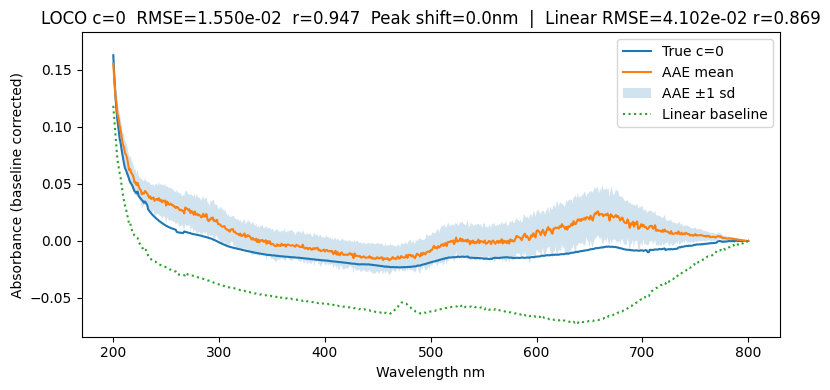

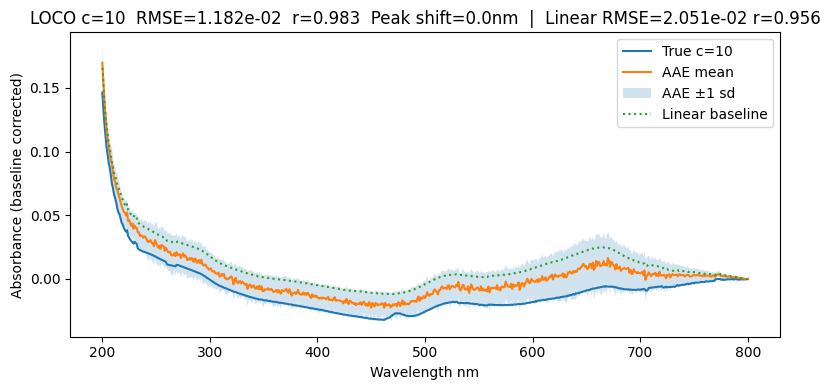

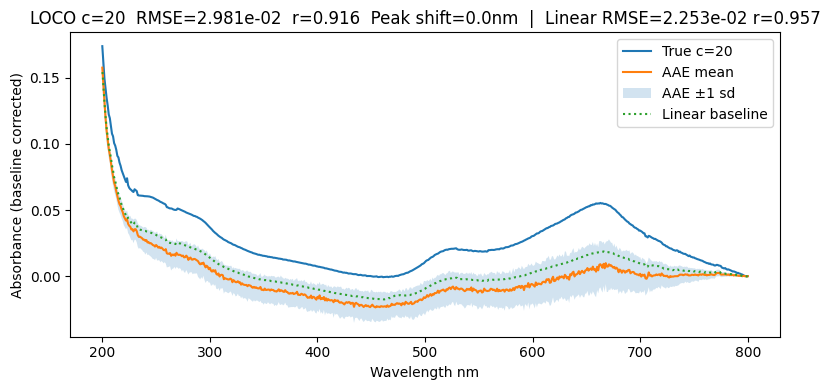

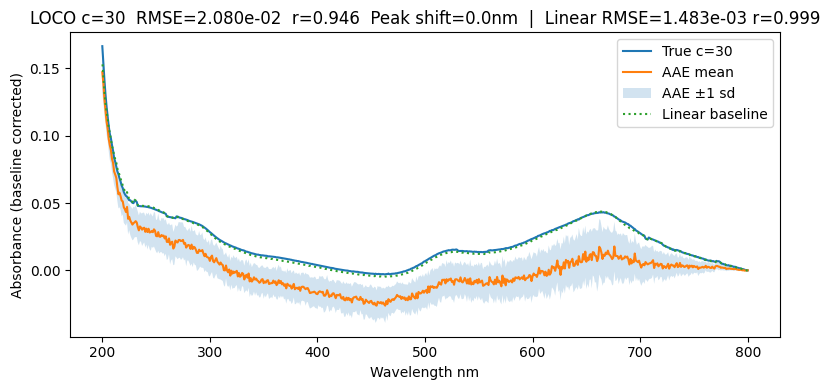

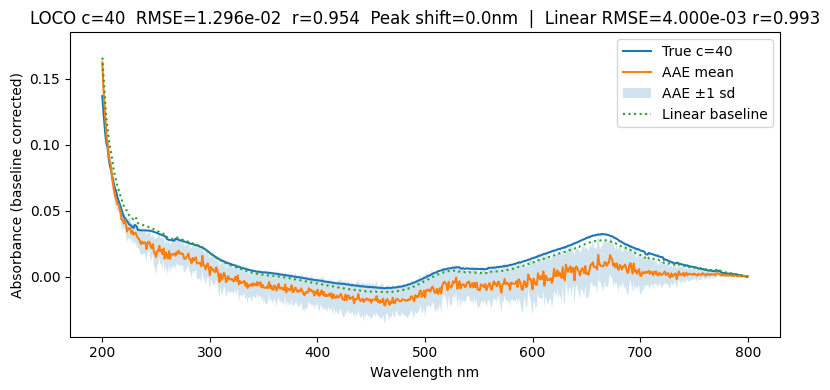

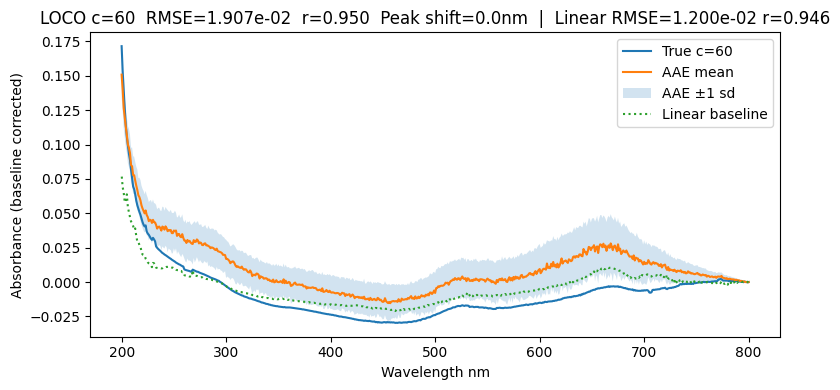

c_hold | RMSE_AAE | r_AAE | PeakShift_nm | RMSE_Lin | r_Lin
    0 | 1.550e-02 | 0.947 |   0.00       | 4.102e-02 | 0.869
   10 | 1.182e-02 | 0.983 |   0.00       | 2.051e-02 | 0.956
   20 | 2.981e-02 | 0.916 |   0.00       | 2.253e-02 | 0.957
   30 | 2.080e-02 | 0.946 |   0.00       | 1.483e-03 | 0.999
   40 | 1.296e-02 | 0.954 |   0.00       | 4.000e-03 | 0.993
   60 | 1.907e-02 | 0.950 |   0.00       | 1.200e-02 | 0.946


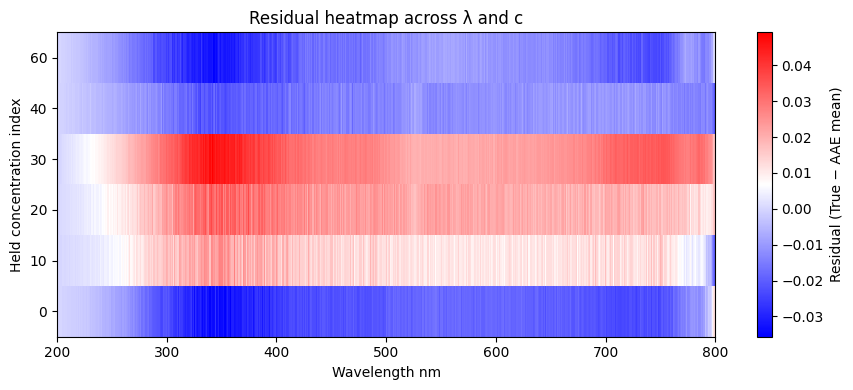

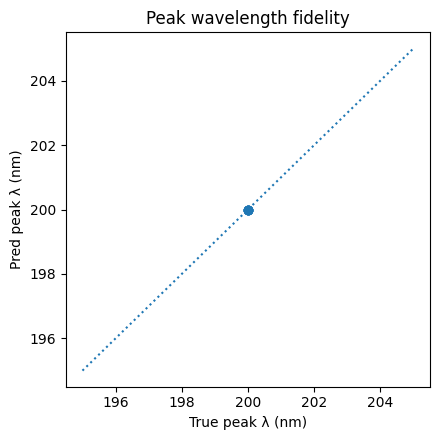

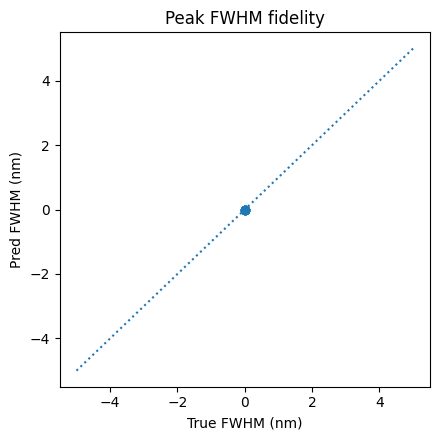

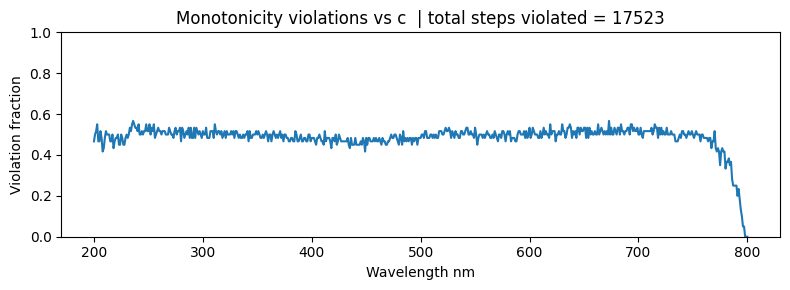

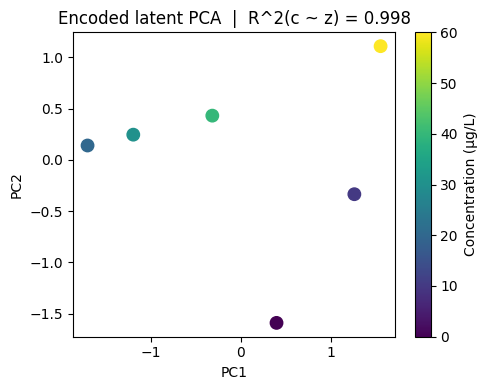

In [ ]:
# ====== Quick diagnostics: 5 easiest, high-signal tests ======
import os, json, numpy as np, torch, matplotlib.pyplot as plt

assert 'wl' in globals() and 'concs_all' in globals() and 'SPECTRA' in globals(), "Run your data loader first"
assert 'load_fold' in globals() and 'decode_many' in globals() and 'linear_baseline_interp' in globals(), "Run your AAE code first"

# ---------- helpers ----------
def fwhm_nm(wl, y):
    y = np.asarray(y)
    p = int(np.argmax(y))
    half = y[p] / 2.0
    # left crossing
    li = p
    while li > 0 and y[li] > half: li -= 1
    if li == p:
        left = wl[p]
    else:
        # linear interp between li and li+1
        x0, x1 = wl[li], wl[li+1]; y0, y1 = y[li], y[li+1]
        left = x0 if y1==y0 else x0 + (half - y0) * (x1 - x0) / (y1 - y0)
    # right crossing
    ri = p
    while ri < len(y)-1 and y[ri] > half: ri += 1
    if ri == p:
        right = wl[p]
    else:
        x0, x1 = wl[ri-1], wl[ri]; y0, y1 = y[ri-1], y[ri]
        right = x1 if y1==y0 else x0 + (half - y0) * (x1 - x0) / (y1 - y0)
    return max(0.0, float(right - left))

def rmse(a, b): a = np.asarray(a); b = np.asarray(b); return float(np.sqrt(np.mean((a-b)**2)))
def pearsonr(a, b):
    a = np.asarray(a); b = np.asarray(b)
    a = a - a.mean(); b = b - b.mean()
    den = np.sqrt((a*a).sum()) * np.sqrt((b*b).sum()) + 1e-12
    return float((a*b).sum() / den)

def peak_nm(wl, y): return float(wl[int(np.argmax(y))])

def load_fold_pack(c_hold):
    fold_dir = os.path.join(CKPT_ROOT, f"fold_{int(c_hold)}")
    if not os.path.exists(os.path.join(fold_dir, "encoder.pt")):
        raise FileNotFoundError(f"Missing {fold_dir}. Train LOCO folds first.")
    enc, dec, disc, aux, cemb, scaler, meta = load_fold(fold_dir)
    return {"enc":enc, "dec":dec, "aux":aux, "cemb":cemb, "scaler":scaler, "meta":meta}

def aae_mean_std_at(c_hold, N=128, mode="conditional"):
    P = load_fold_pack(c_hold); L = P["meta"]["latent_dim"]; E = P["meta"]["c_emb_dim"]
    if mode == "conditional":
        X = decode_many(P["dec"], P["cemb"], P["scaler"], float(c_hold), N, L, E)
    else:
        # fallback to conditional for simplicity here
        X = decode_many(P["dec"], P["cemb"], P["scaler"], float(c_hold), N, L, E)
    return X.mean(axis=0), X.std(axis=0)

# ---------- 1) LOCO overlay with uncertainty and linear baseline ----------
rows = []
for c_hold in concs_all:
    P = load_fold_pack(c_hold)
    train_concs = [float(c) for c in concs_all if float(c) != float(c_hold)]
    A_train = np.stack([SPECTRA[float(c)] for c in train_concs], axis=1)
    lin_pred = linear_baseline_interp(train_concs, A_train, float(c_hold))

    mean_pred, std_pred = aae_mean_std_at(c_hold, N=128, mode="conditional")
    x_true = SPECTRA[float(c_hold)]

    r = pearsonr(x_true, mean_pred)
    e = rmse(x_true, mean_pred)
    pshift = abs(peak_nm(wl, x_true) - peak_nm(wl, mean_pred))
    r_lin = pearsonr(x_true, lin_pred)
    e_lin = rmse(x_true, lin_pred)

    plt.figure(figsize=(8,4))
    plt.plot(wl, x_true, label=f"True c={int(c_hold)}")
    plt.plot(wl, mean_pred, label="AAE mean")
    plt.fill_between(wl, mean_pred-std_pred, mean_pred+std_pred, alpha=0.2, label="AAE ±1 sd")
    plt.plot(wl, lin_pred, linestyle=":", label="Linear baseline")
    plt.title(f"LOCO c={int(c_hold)}  RMSE={e:.3e}  r={r:.3f}  Peak shift={pshift:.1f}nm  |  Linear RMSE={e_lin:.3e} r={r_lin:.3f}")
    plt.xlabel("Wavelength nm"); plt.ylabel("Absorbance (baseline corrected)"); plt.legend(); plt.tight_layout(); plt.show()

    rows.append((float(c_hold), e, r, pshift, e_lin, r_lin))

# quick table print
print("c_hold | RMSE_AAE | r_AAE | PeakShift_nm | RMSE_Lin | r_Lin")
for r in rows:
    print(f"{int(r[0]):>5} | {r[1]:.3e} | {r[2]:.3f} | {r[3]:6.2f}       | {r[4]:.3e} | {r[5]:.3f}")

# ---------- 2) Residual heatmap across wavelength and concentration ----------
res_mat = []
for c_hold in concs_all:
    mean_pred, _ = aae_mean_std_at(c_hold, N=128)
    x_true = SPECTRA[float(c_hold)]
    res_mat.append(x_true - mean_pred)
res_mat = np.stack(res_mat, axis=0)  # [C, 601]

plt.figure(figsize=(9,4))
extent = [float(wl.min()), float(wl.max()), float(concs_all.min()), float(concs_all.max())]
plt.imshow(res_mat, aspect="auto", cmap="bwr", interpolation="nearest",
           extent=[extent[0], extent[1], 0, len(concs_all)])
plt.colorbar(label="Residual (True − AAE mean)")
plt.yticks(ticks=np.arange(len(concs_all))+0.5, labels=[int(c) for c in concs_all])
plt.xlabel("Wavelength nm"); plt.ylabel("Held concentration index"); plt.title("Residual heatmap across λ and c"); plt.tight_layout(); plt.show()

# ---------- 3) Peak shape fidelity: peak λ and FWHM ----------
true_peaks = []; pred_peaks = []; true_fwhm = []; pred_fwhm = []
for c_hold in concs_all:
    x_true = SPECTRA[float(c_hold)]
    mean_pred, _ = aae_mean_std_at(c_hold, N=128)
    true_peaks.append(peak_nm(wl, x_true))
    pred_peaks.append(peak_nm(wl, mean_pred))
    true_fwhm.append(fwhm_nm(wl, x_true))
    pred_fwhm.append(fwhm_nm(wl, mean_pred))

# peak λ scatter
plt.figure(figsize=(4.5,4.5))
plt.scatter(true_peaks, pred_peaks)
mn, mx = min(true_peaks+pred_peaks)-5, max(true_peaks+pred_peaks)+5
plt.plot([mn,mx],[mn,mx], linestyle=":")
plt.xlabel("True peak λ (nm)"); plt.ylabel("Pred peak λ (nm)")
plt.title("Peak wavelength fidelity"); plt.tight_layout(); plt.show()

# FWHM scatter
plt.figure(figsize=(4.5,4.5))
plt.scatter(true_fwhm, pred_fwhm)
mn, mx = min(true_fwhm+pred_fwhm)-5, max(true_fwhm+pred_fwhm)+5
plt.plot([mn,mx],[mn,mx], linestyle=":")
plt.xlabel("True FWHM (nm)"); plt.ylabel("Pred FWHM (nm)")
plt.title("Peak FWHM fidelity"); plt.tight_layout(); plt.show()

# ---------- 4) Monotonicity violations across concentration ----------
# Use a single well-trained fold to decode across full c-grid to avoid mixing decoders
center_c = float(sorted(concs_all, key=lambda x: abs(x - np.median(concs_all)))[0])
P0 = load_fold_pack(center_c)
L, E = P0["meta"]["latent_dim"], P0["meta"]["c_emb_dim"]

c_grid = np.linspace(float(concs_all.min()), float(concs_all.max()), 61)  # 1-unit grid
A_grid = []
for c in c_grid:
    X = decode_many(P0["dec"], P0["cemb"], P0["scaler"], float(c), N=64, latent_dim=L, c_emb_dim=E)
    A_grid.append(X.mean(axis=0))
A_grid = np.stack(A_grid, axis=0)  # [61, 601]

eps = 1e-4
overall_sign = np.sign(A_grid[-1] - A_grid[0])
local_diff = np.diff(A_grid, axis=0)  # [60, 601]
local_sign = np.sign(local_diff)
mask_small = np.abs(local_diff) < eps
viol = (local_sign != np.sign(overall_sign)).astype(np.float32)
viol[mask_small] = 0.0
viol_frac = viol.mean(axis=0)  # per wavelength
total_viol = int(viol.sum())

plt.figure(figsize=(8,3))
plt.plot(wl, viol_frac)
plt.ylim(0, 1.0)
plt.xlabel("Wavelength nm"); plt.ylabel("Violation fraction")
plt.title(f"Monotonicity violations vs c  | total steps violated = {total_viol}")
plt.tight_layout(); plt.show()

# ---------- 5) Latent usefulness: PCA map of encoded real spectra with linearity score ----------
# Encode the six real spectra using the same scaler and encoder from the center fold
X_real = np.stack([SPECTRA[float(c)] for c in concs_all], axis=0)  # [6, 601]
Xz = P0["scaler"].transform(X_real).astype(np.float32)
with torch.no_grad():
    z = P0["enc"](torch.from_numpy(Xz).to(next(P0["enc"].parameters()).device)).cpu().numpy()  # [6, L]

# PCA to 2D
z_centered = z - z.mean(axis=0, keepdims=True)
U, S, Vt = np.linalg.svd(z_centered, full_matrices=False)
Z2 = U[:, :2] * S[:2]  # [6,2]

# Linear regression c ~ z
Z_aug = np.concatenate([z, np.ones((z.shape[0],1))], axis=1)  # bias
coef, *_ = np.linalg.lstsq(Z_aug, concs_all.reshape(-1,1), rcond=None)
c_pred = Z_aug @ coef
ss_res = float(((concs_all.reshape(-1,1) - c_pred)**2).sum())
ss_tot = float(((concs_all - concs_all.mean())**2).sum())
r2 = 1.0 - ss_res / (ss_tot + 1e-12)

plt.figure(figsize=(5,4))
sc = plt.scatter(Z2[:,0], Z2[:,1], c=concs_all, s=80)
plt.colorbar(sc, label="Concentration (µg/L)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"Encoded latent PCA  |  R^2(c ~ z) = {r2:.3f}")
plt.tight_layout(); plt.show()
